In [1]:
%qtconsole

In [2]:
%pip install deeptrack==0.11.3

import numpy as np
import deeptrack as dt
import matplotlib.pyplot as plt
plt.style.use('default')
import ipywidgets as widgets

Note: you may need to restart the kernel to use updated packages.


In [3]:
IMAGE_SIZE = 64
SAMPLE_THICKNESS = 300

Om man väljer partikelradien till en meter, varför ser det normalt ut?

In [4]:
particle = dt.MieSphere(
    position = (IMAGE_SIZE / 2, IMAGE_SIZE / 2) + np.random.rand(2) * 4 - 2, #lambda: (IMAGE_SIZE / 2, IMAGE_SIZE / 2) + np.random.rand(2) * IMAGE_SIZE - IMAGE_SIZE / 2,
    z = lambda: np.random.uniform(-SAMPLE_THICKNESS / 2, SAMPLE_THICKNESS / 2),
    radius = lambda: (1e-7 + 3e-7 * np.random.rand()),
    refractive_index = lambda: np.random.rand() * 0.3 + 1.37,
    L = 8,
    position_unit = 'pixel'
)

In [5]:
HC = dt.HorizontalComa(coefficient= lambda c1: c1, c1 = 0 + np.random.randn() * 0.05)
VC = dt.VerticalComa(coefficient= lambda c2: c2, c2 = 0 + np.random.randn() * 0.05)

def crop(pupil_radius):
    def inner(image):
        x = np.arange(image.shape[0]) - image.shape[0] / 2
        y = np.arange(image.shape[1]) - image.shape[1] / 2
        X, Y = np.meshgrid(x, y)
        image[X ** 2 + Y ** 2 > pupil_radius ** 2] = 0
        return image
    return inner

CROP = dt.Lambda(crop, pupil_radius = 23)

optics = dt.Brightfield(
    NA = 1.3,
    resolution = 1.13e-6,
    wavelength= 635e-9,
    aperture_angle= 53.7 * 2 * np.pi / 360,
    polarization_angle= lambda: np.random.rand() * 2 * np.pi,
    magnification= 10,
    output_region= (0, 0, IMAGE_SIZE, IMAGE_SIZE),
    padding= (64,) * 4,
    return_field = True,
    pupil = HC + VC + CROP
)

In [6]:
real_noise = dt.Gaussian(
    mu = 0,
    sigma = lambda level: np.random.rand() * 0.02
)

noise = real_noise + dt.Gaussian(
    mu = 0,
    sigma = lambda real_sigma: real_sigma * 0.03j,
    real_sigma = real_noise.sigma
)

def func():
    def inner(image):
        image = (image - 1)
        output = np.zeros((*image.shape[:2], 2))
        output[..., 0:1] = np.real(image)
        output[..., 1:2] = np.imag(image)
        return output
    return inner

complex_to_float = dt.Lambda(func)

In [7]:
dataset = optics(particle**1 + noise) + complex_to_float

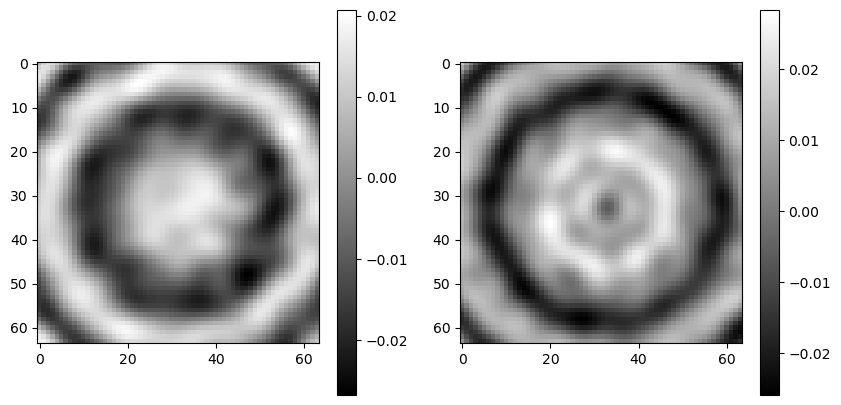

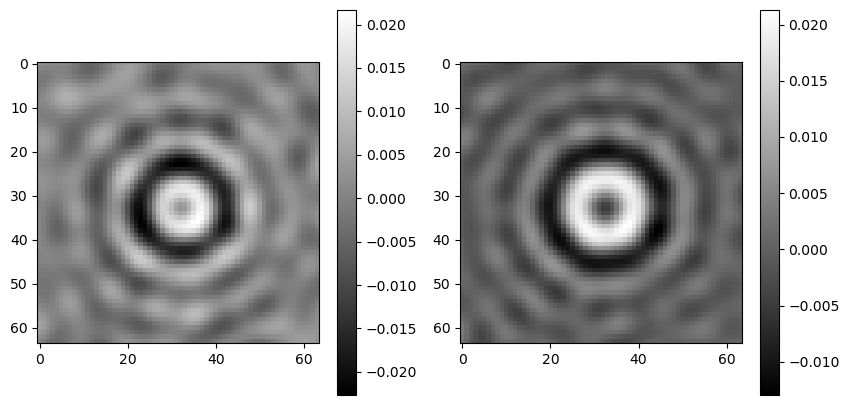

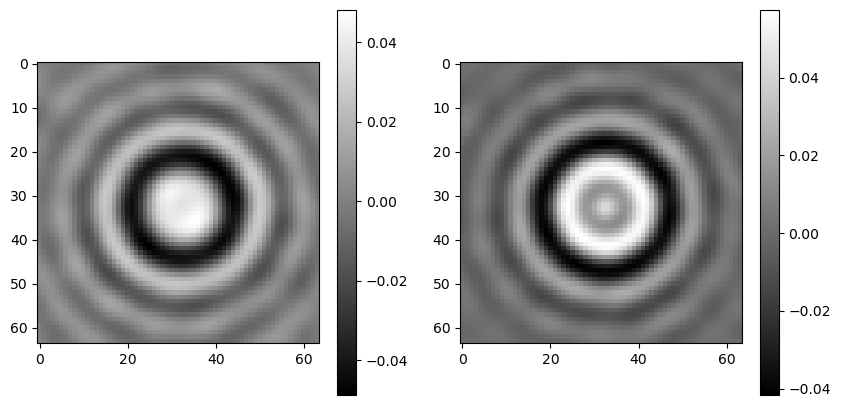

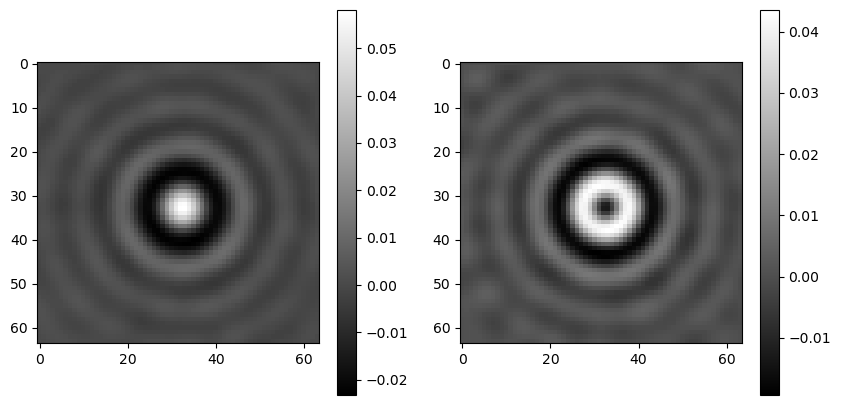

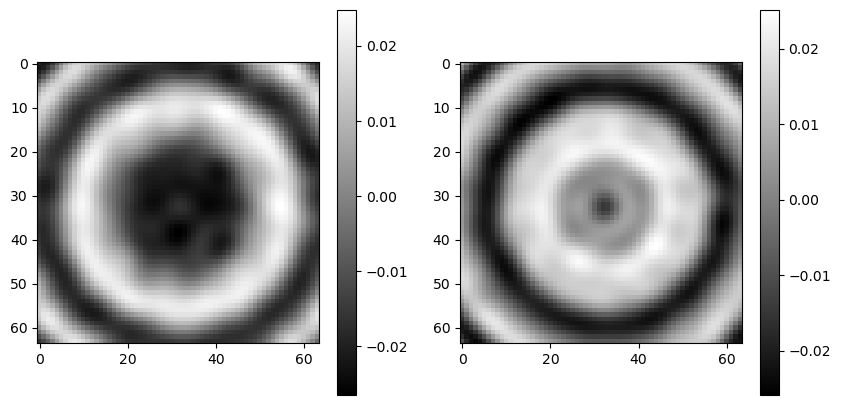

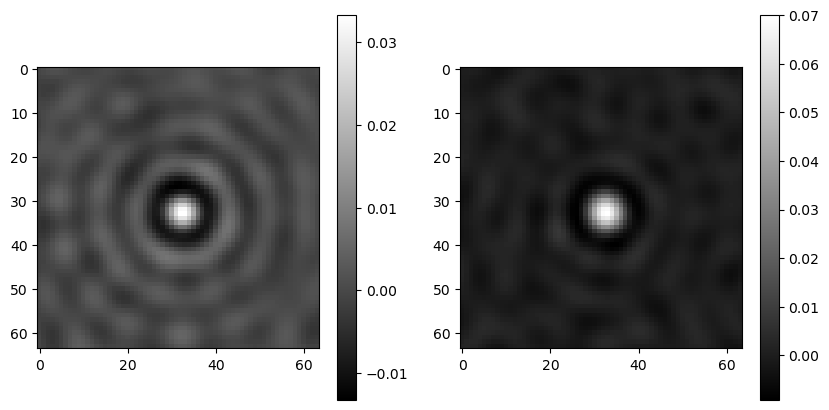

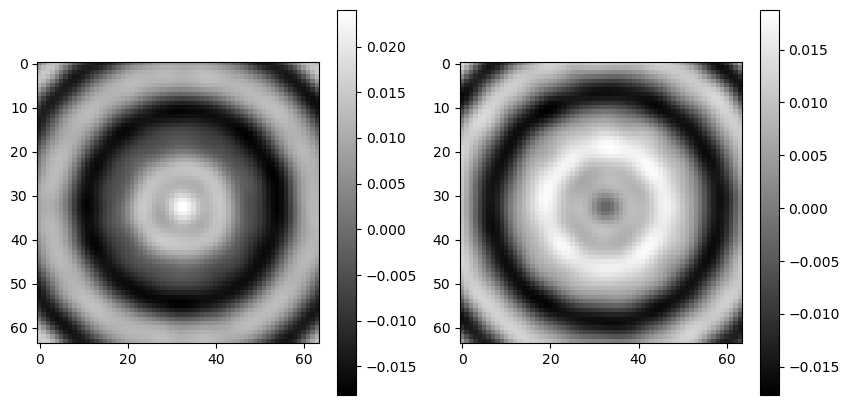

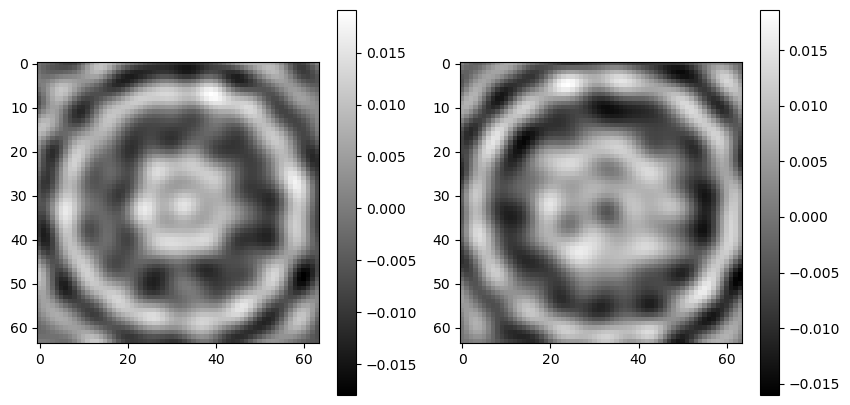

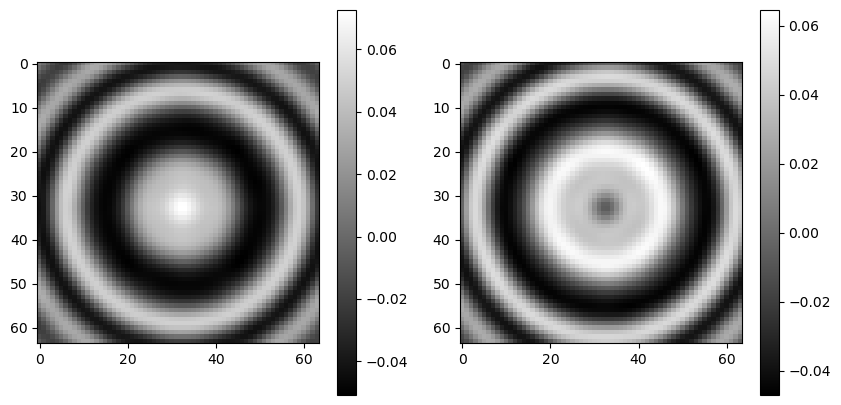

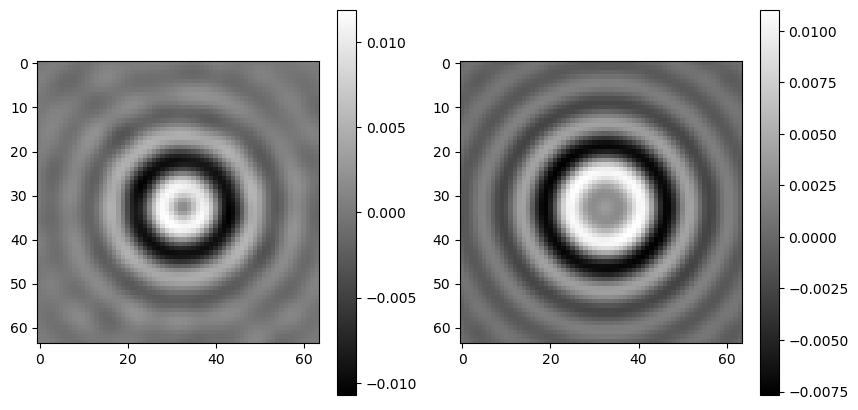

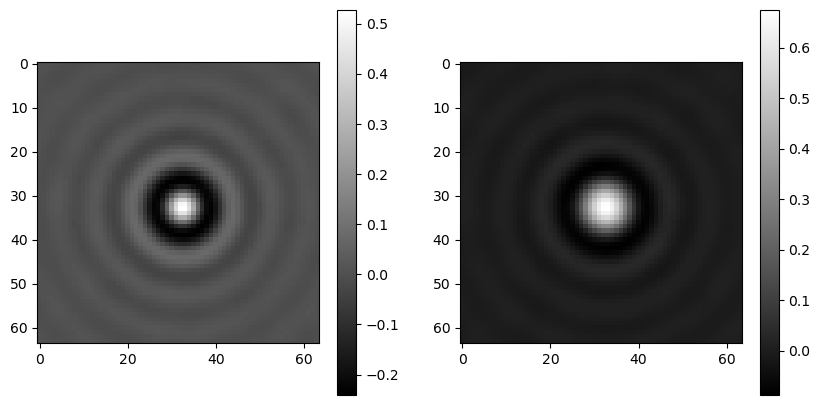

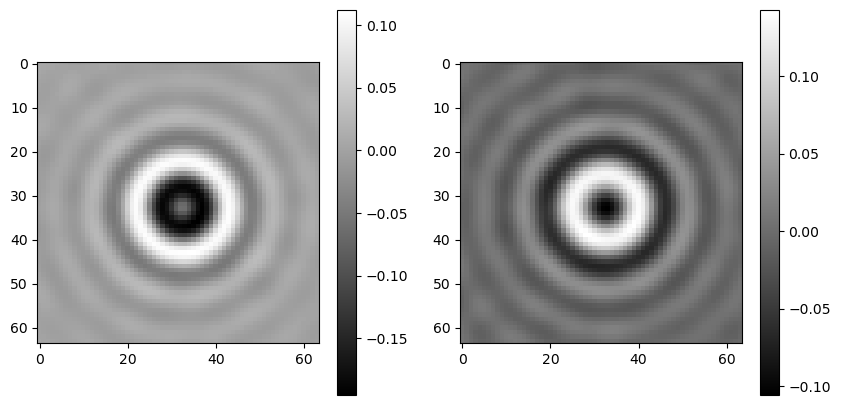

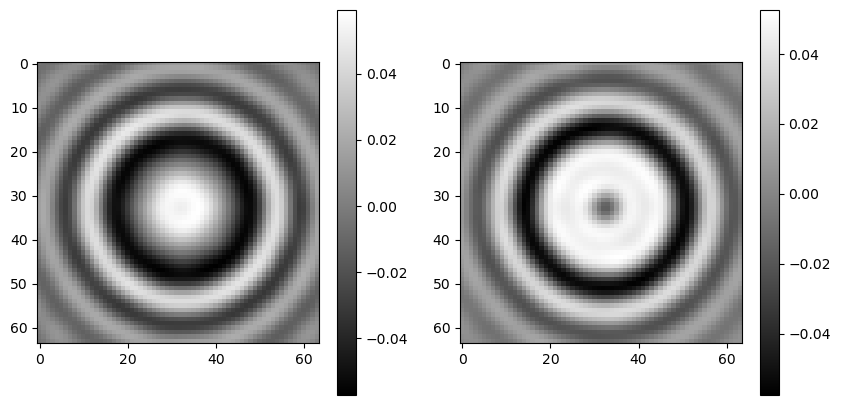

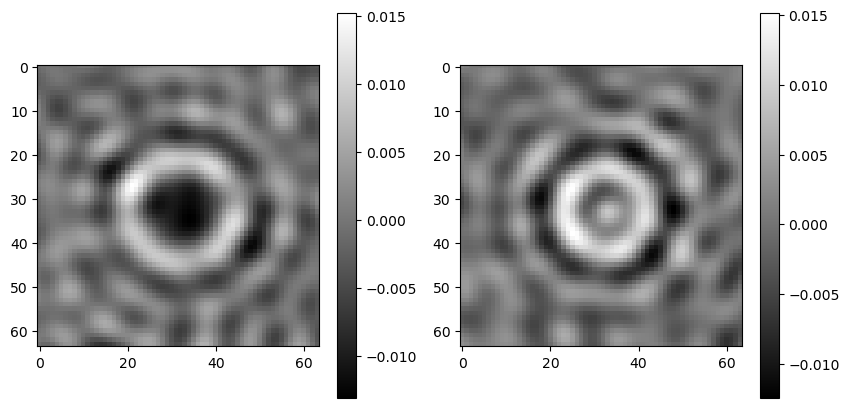

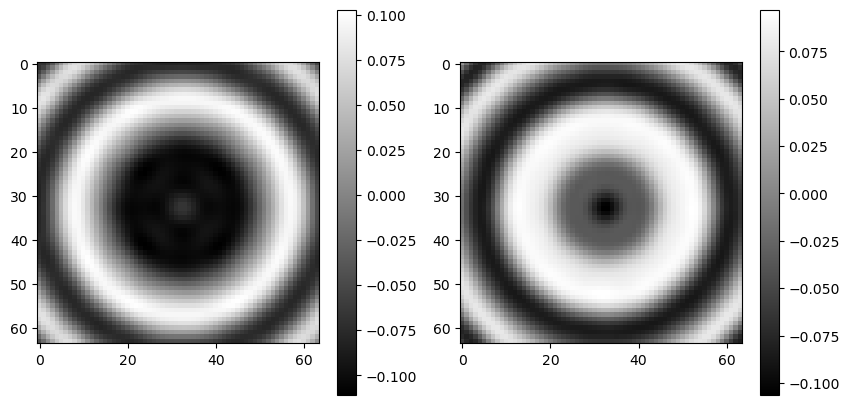

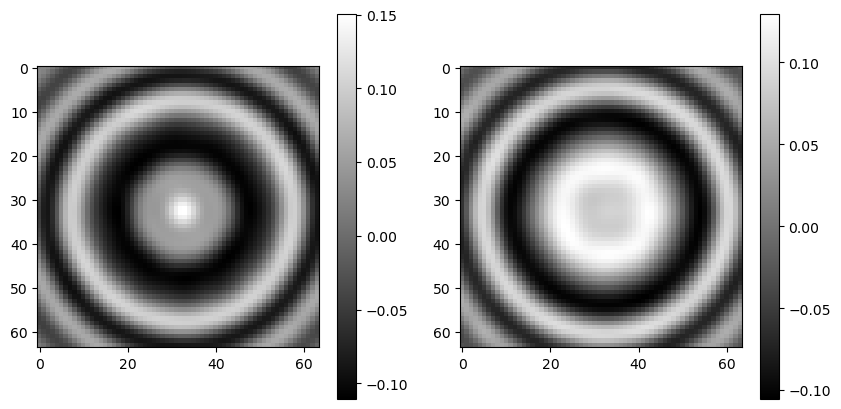

In [8]:
for i in range(16):
    dataset.update()
    image_of_particle = dataset.resolve()

    plt.figure(figsize = (10, 5))
    
    plt.subplot(1,2,1)
    plt.imshow(image_of_particle[:, :, 0], cmap = 'gray')
    plt.colorbar()

    plt.subplot(1,2,2)
    plt.imshow(image_of_particle[:, :, 1], cmap = 'gray')
    plt.colorbar()
    
    plt.show()

### 2. Network design

In [9]:
def get_label(image):
    z = (image.get_property('z') + SAMPLE_THICKNESS / 2) / SAMPLE_THICKNESS
    return z

In [10]:
import keras.backend as K
import keras.optimizers as optimizers

model = dt.models.Convolutional(
    input_shape= (IMAGE_SIZE, IMAGE_SIZE, 2),
    conv_layers_dimensions= (32, 64, 128),
    dense_layers_dimensions= (64, 64),
    steps_per_pooling= 2,
    number_of_outputs= 1,
    dropout= (.2, .2),
    loss= 'mae',
    optimizer= 'adam',
    dense_block= dt.layers.DenseBlock(activation='relu')
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 2)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        608       
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 spatial_dropout2d (SpatialD  (None, 64, 64, 32)       0         
 ropout2D)                                                       
                                                             

2022-01-31 10:20:08.411243: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
from tensorflow.keras.callbacks import EarlyStopping

validation_set_size = 256
validation_set = [dataset.update().resolve() for _ in range(validation_set_size)]
validation_labels = [get_label(image) for image in validation_set]

In [12]:
generator = dt.generators.ContinuousGenerator(
    dataset,
    get_label,
    min_data_size= int(64),
    max_data_size= int(2e4),
    batch_size= 64
)

totalhistory = {"training_loss": [], "validation_loss": [], "epoch": [], "validation_predictions": []}

Generating 67 / 64 samples before starting training
1/1 [==============================] - 5s 5s/step - loss: 0.4743 - val_loss: 0.4517


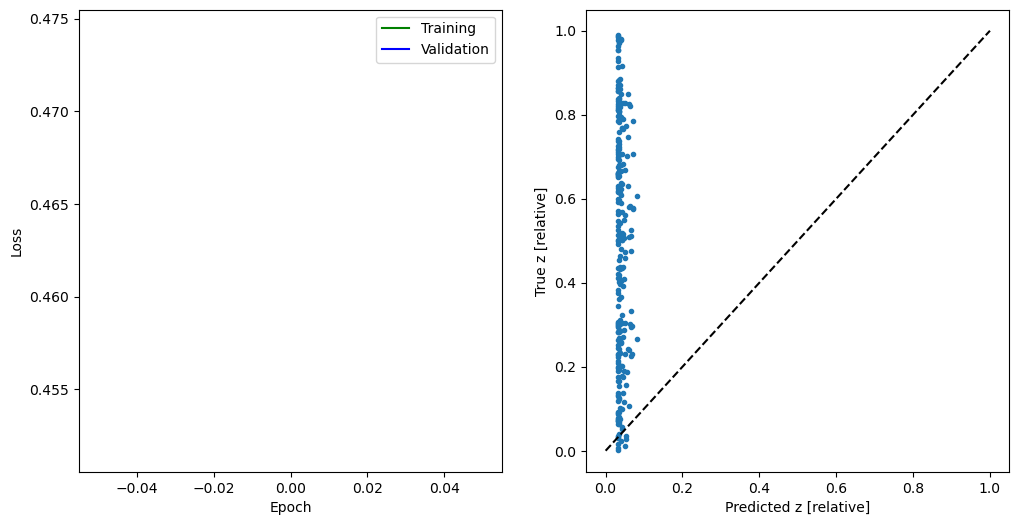

Generating 94 / 64 samples before starting training
1/1 [==============================] - 2s 2s/step - loss: 0.4344 - val_loss: 0.3436


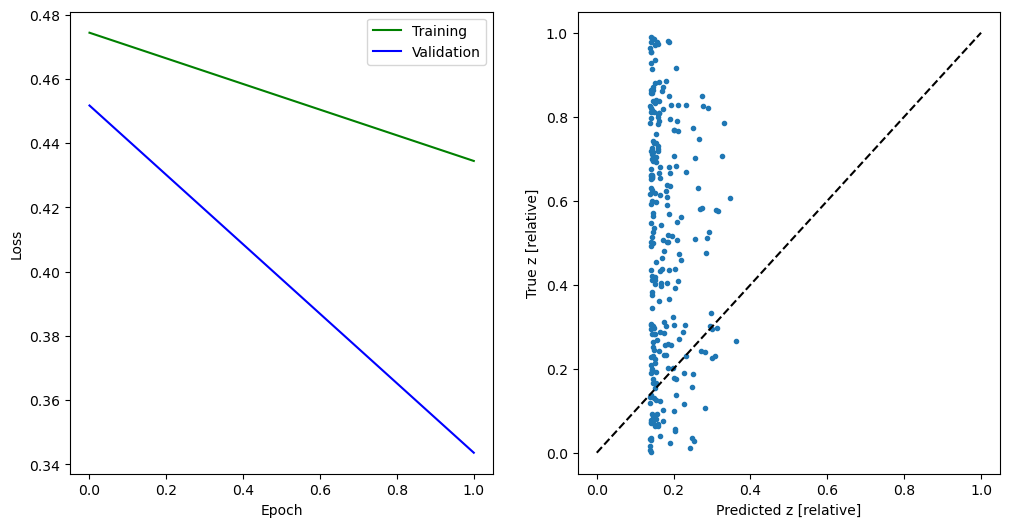

Generating 107 / 64 samples before starting training
1/1 [==============================] - 5s 5s/step - loss: 0.3426 - val_loss: 0.2665


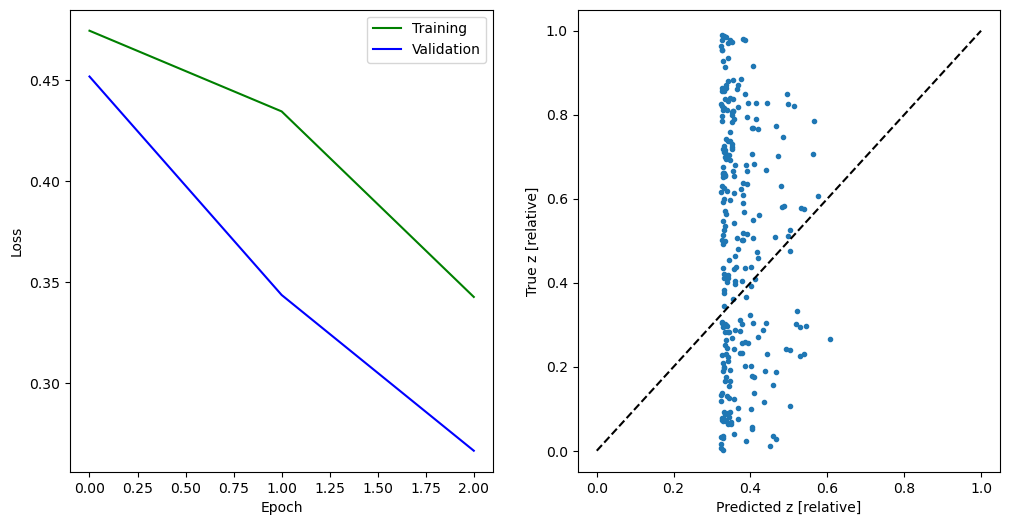

Generating 121 / 64 samples before starting training
1/1 [==============================] - 1s 1s/step - loss: 0.3652 - val_loss: 0.3119


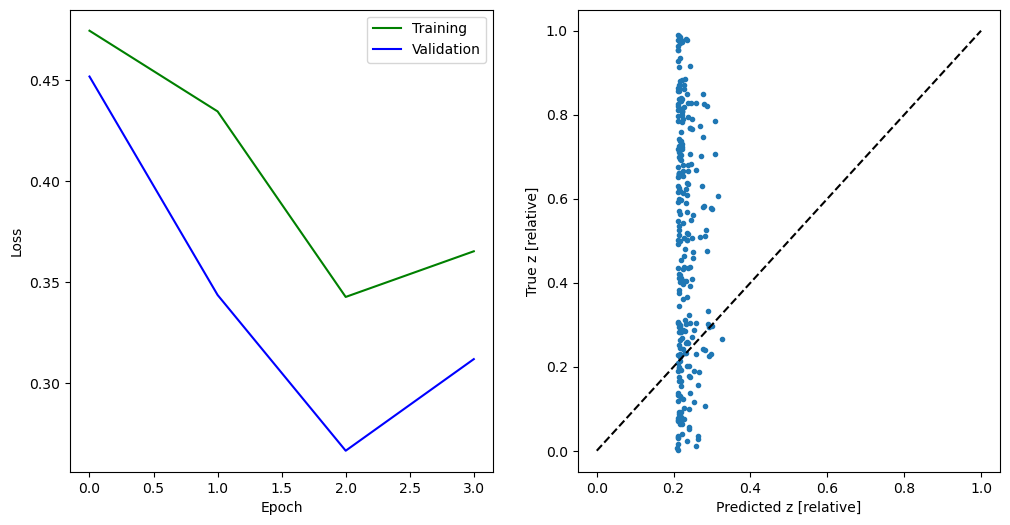

Generating 134 / 64 samples before starting training
2/2 [==============================] - 2s 1s/step - loss: 0.2703 - val_loss: 0.3424


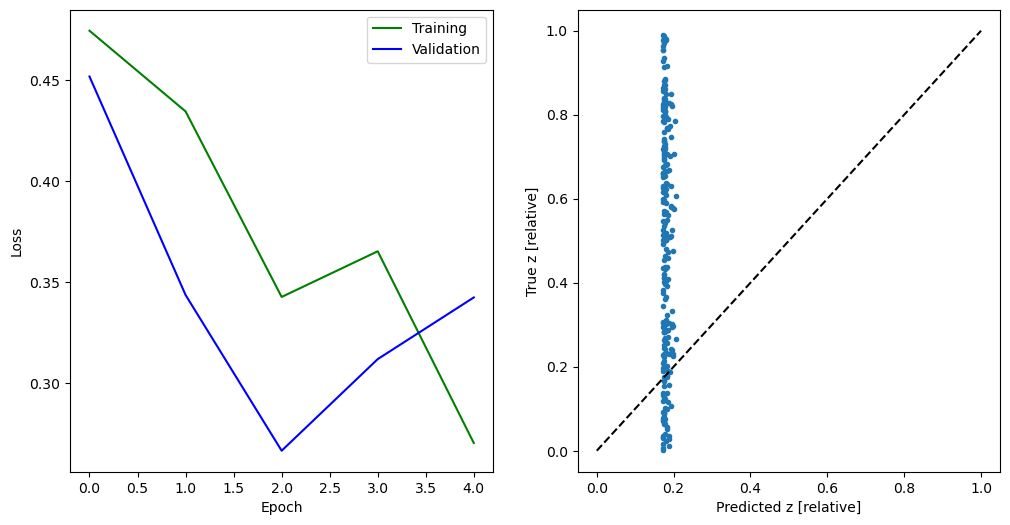

Generating 153 / 64 samples before starting training
2/2 [==============================] - 2s 1s/step - loss: 0.3016 - val_loss: 0.2867


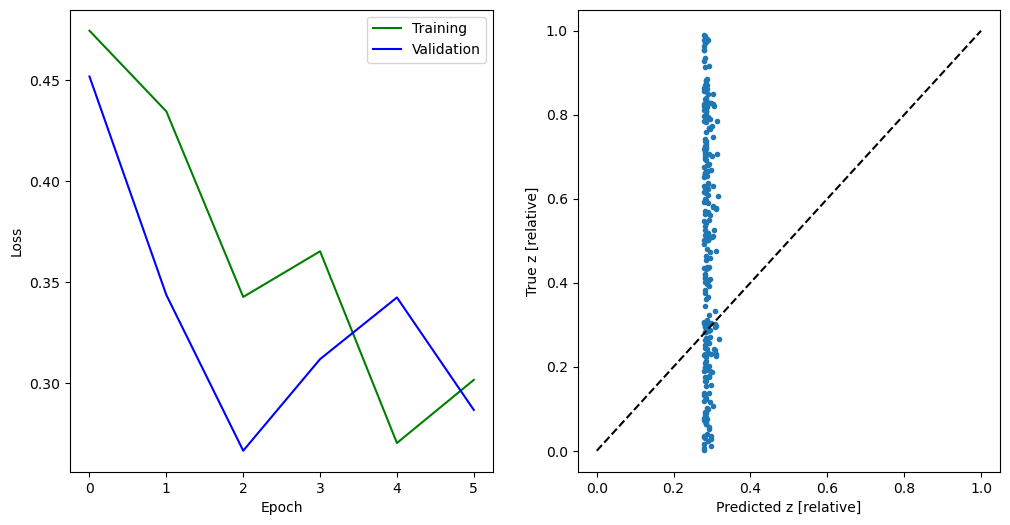

Generating 172 / 64 samples before starting training
2/2 [==============================] - 2s 1s/step - loss: 0.2680 - val_loss: 0.2490


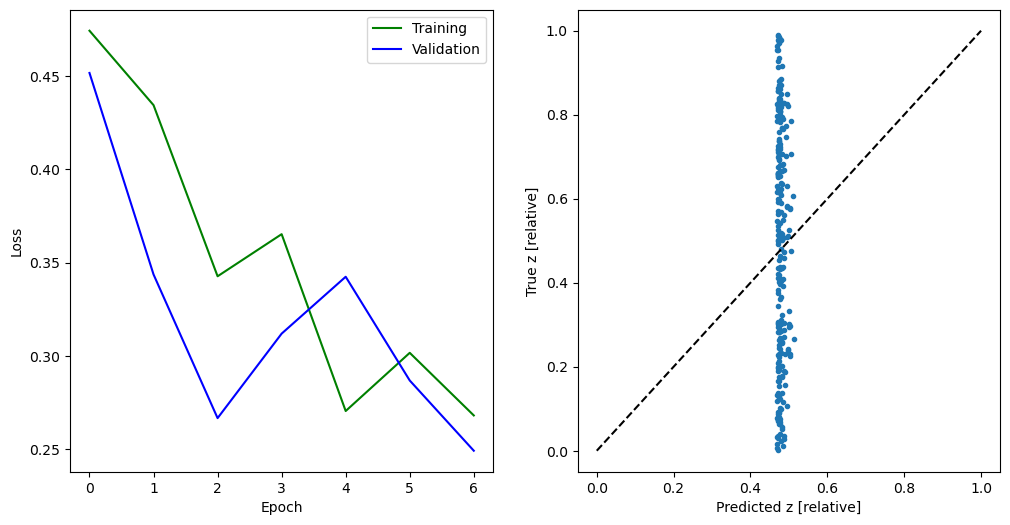

Generating 190 / 64 samples before starting training
2/2 [==============================] - 5s 4s/step - loss: 0.2762 - val_loss: 0.2490


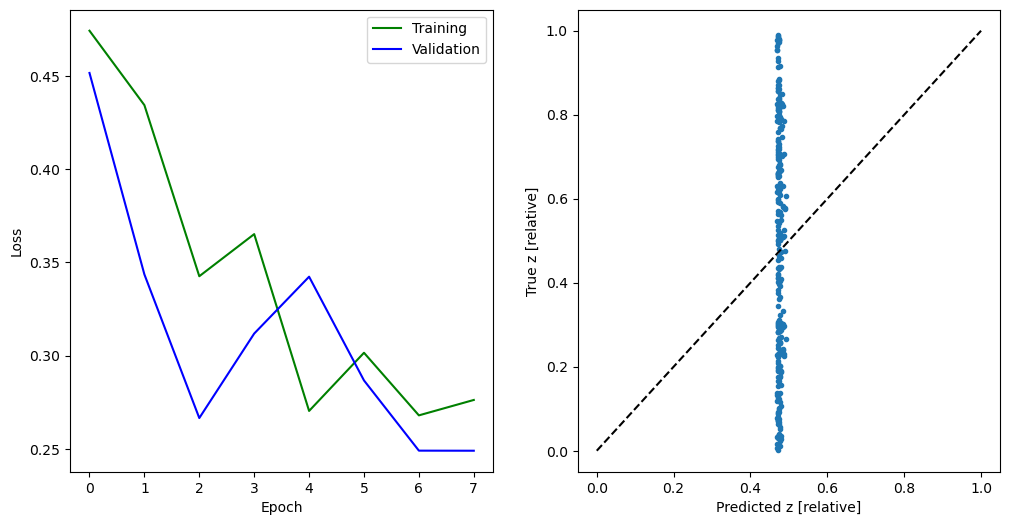

Generating 208 / 64 samples before starting training
3/3 [==============================] - 2s 936ms/step - loss: 0.2659 - val_loss: 0.2572


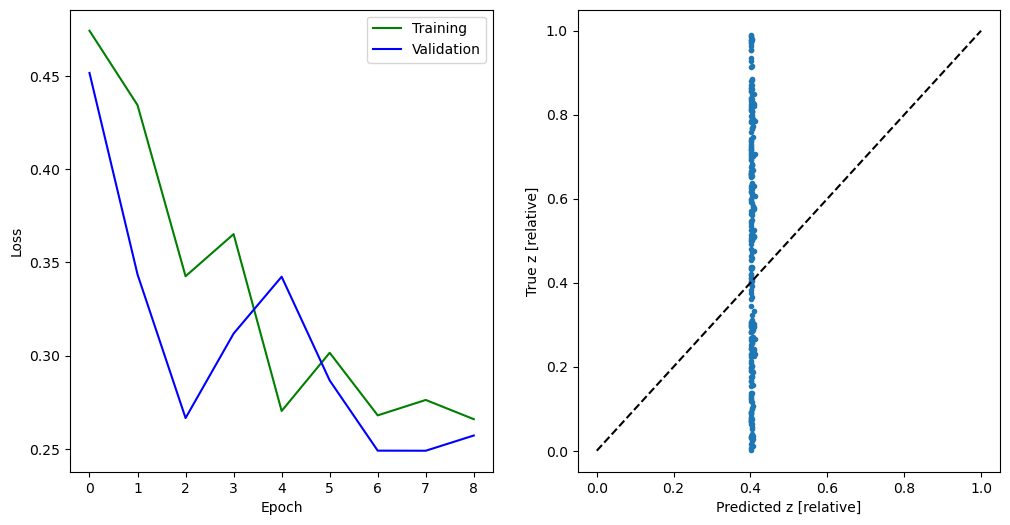

Generating 230 / 64 samples before starting training
3/3 [==============================] - 2s 940ms/step - loss: 0.2572 - val_loss: 0.2482


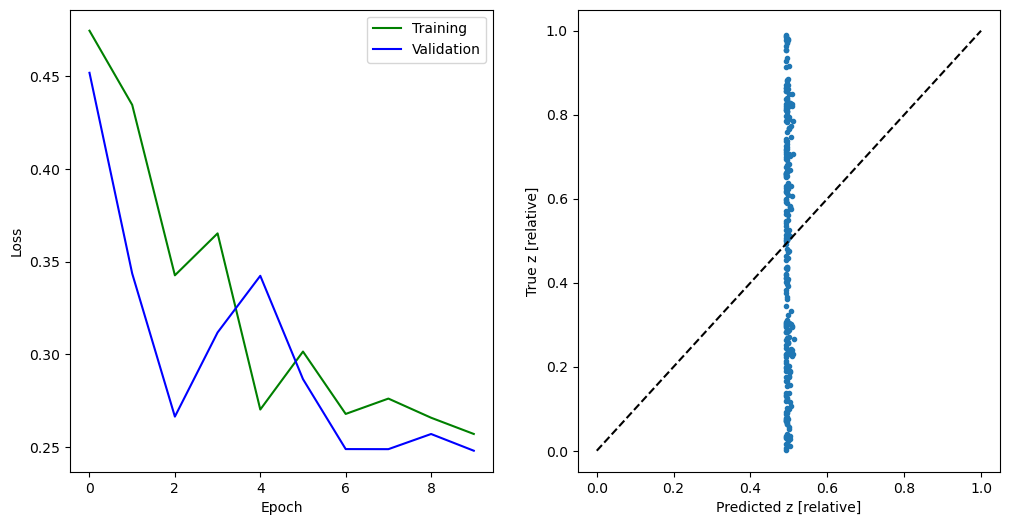

Generating 255 / 64 samples before starting training
3/3 [==============================] - 3s 996ms/step - loss: 0.2600 - val_loss: 0.2499


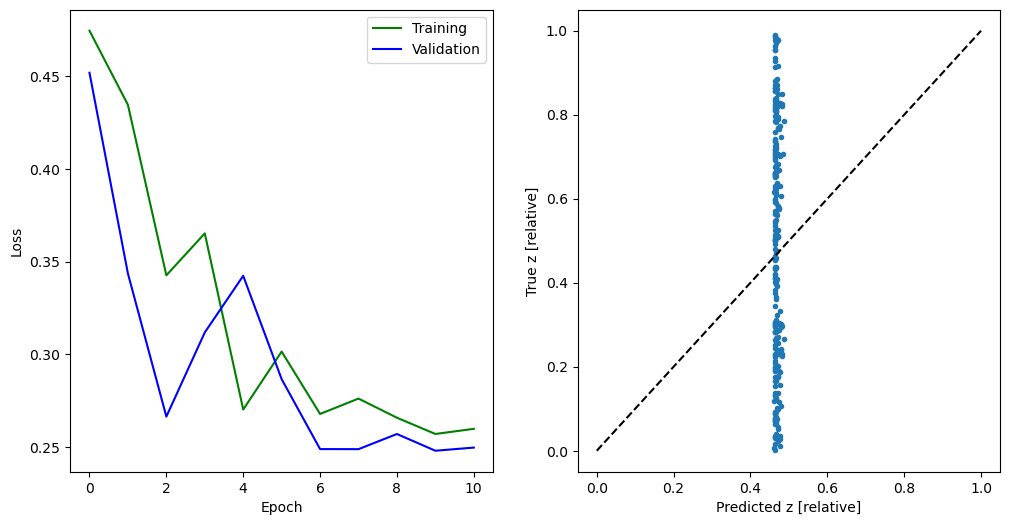

Generating 277 / 64 samples before starting training
4/4 [==============================] - 5s 1s/step - loss: 0.2549 - val_loss: 0.2570


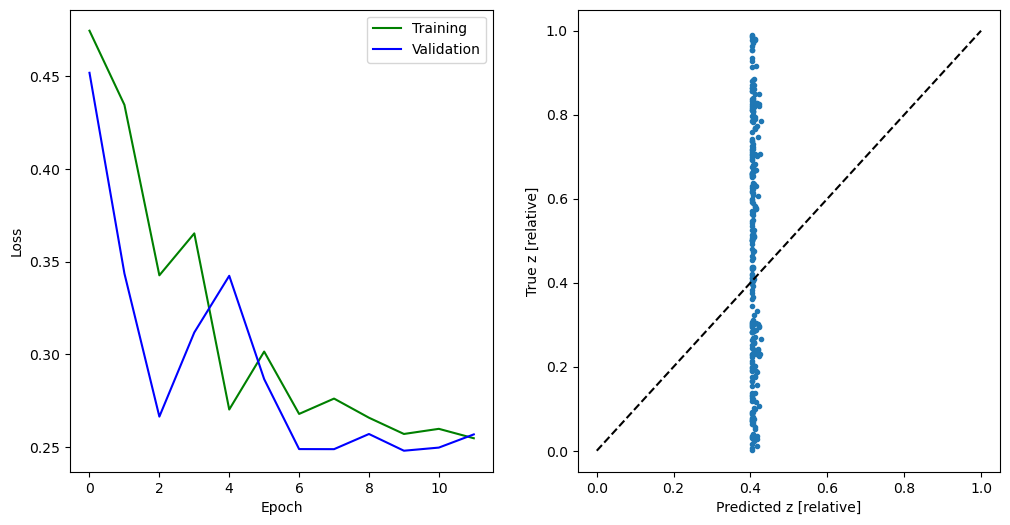

Generating 309 / 64 samples before starting training
4/4 [==============================] - 3s 792ms/step - loss: 0.2616 - val_loss: 0.2517


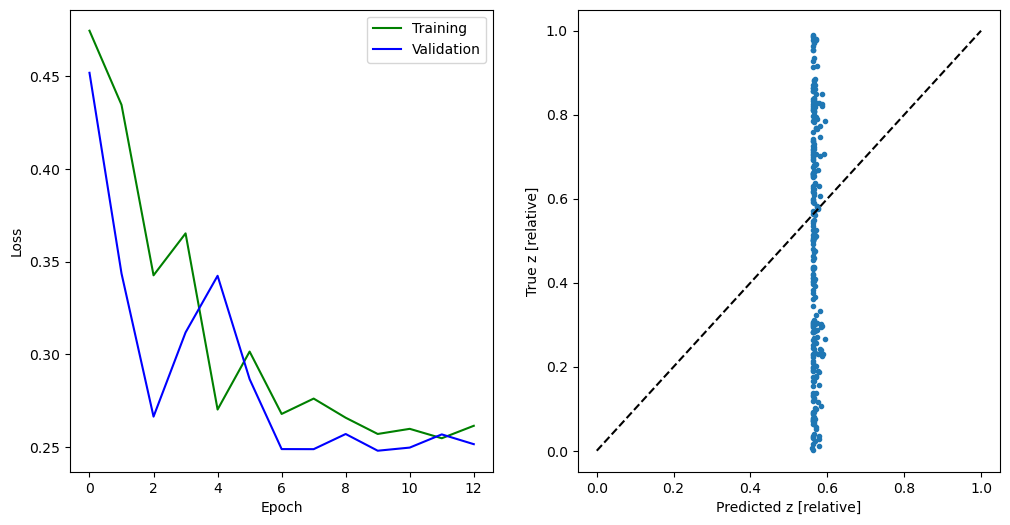

Generating 337 / 64 samples before starting training
5/5 [==============================] - 32s 8s/step - loss: 0.2525 - val_loss: 0.2540


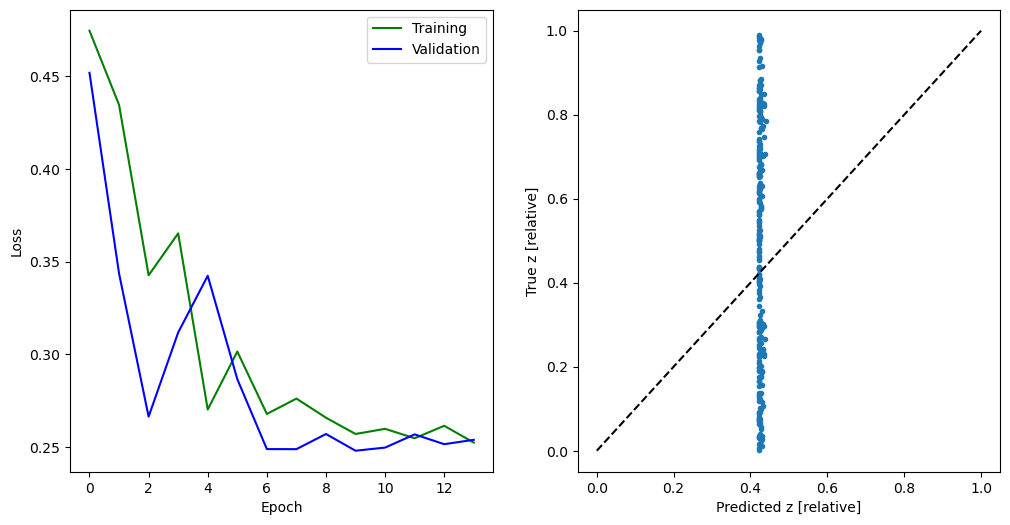

Generating 372 / 64 samples before starting training
5/5 [==============================] - 4s 921ms/step - loss: 0.2632 - val_loss: 0.2479


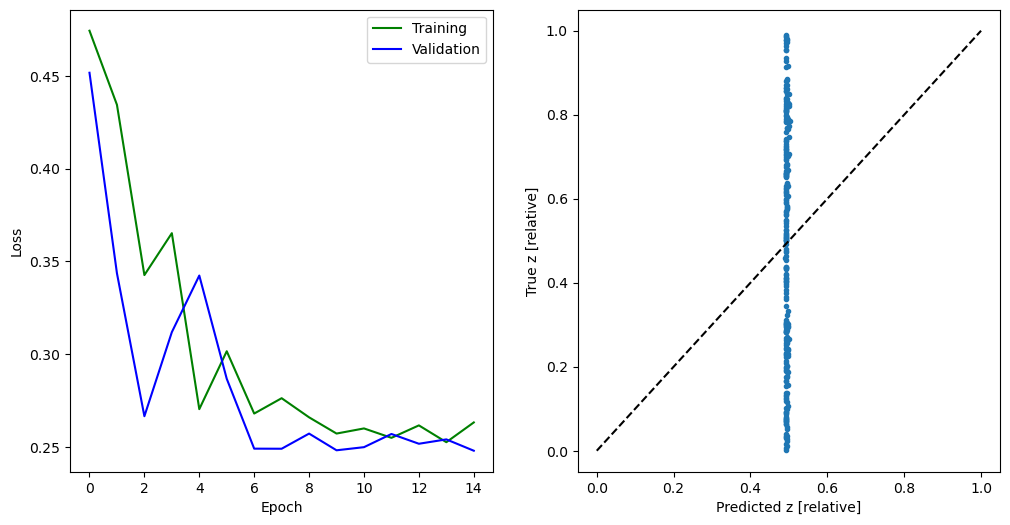

Generating 406 / 64 samples before starting training
6/6 [==============================] - 4s 705ms/step - loss: 0.2489 - val_loss: 0.2491


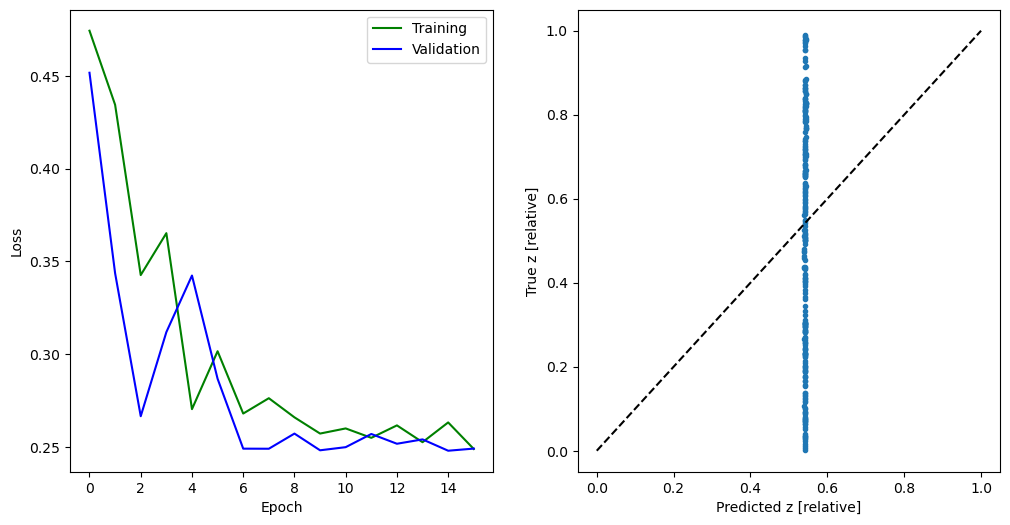

Generating 446 / 64 samples before starting training
6/6 [==============================] - 5s 851ms/step - loss: 0.2512 - val_loss: 0.2557


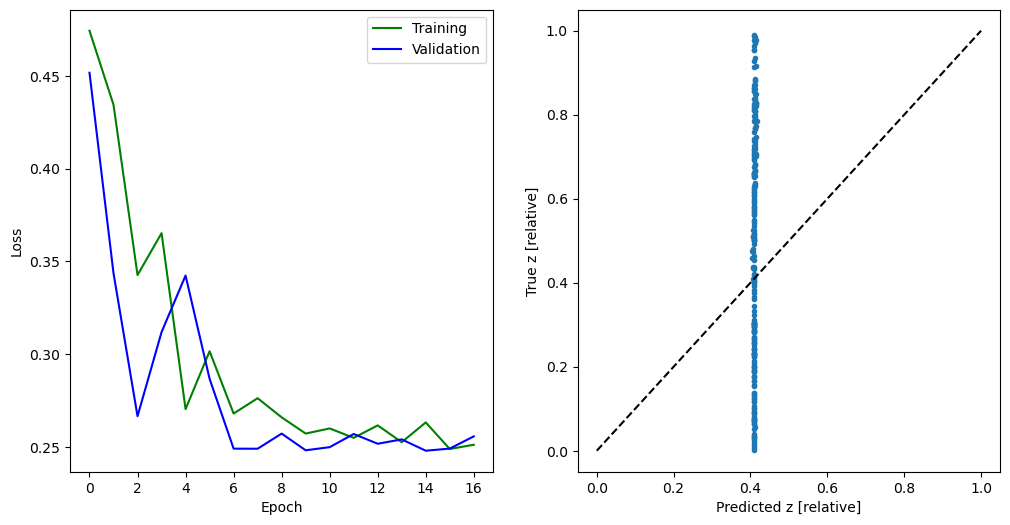

Generating 481 / 64 samples before starting training
7/7 [==============================] - 5s 693ms/step - loss: 0.2506 - val_loss: 0.2483


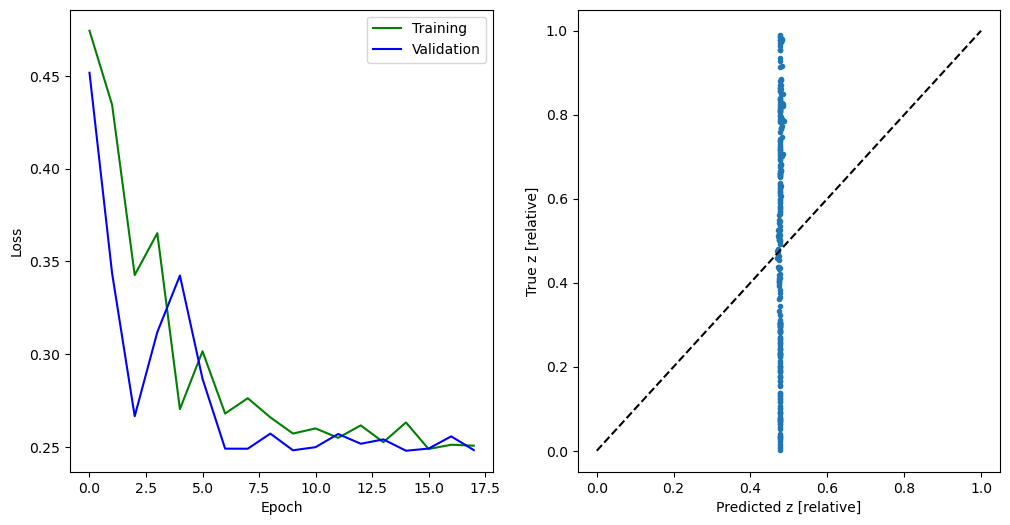

Generating 525 / 64 samples before starting training
8/8 [==============================] - 6s 738ms/step - loss: 0.2514 - val_loss: 0.2495


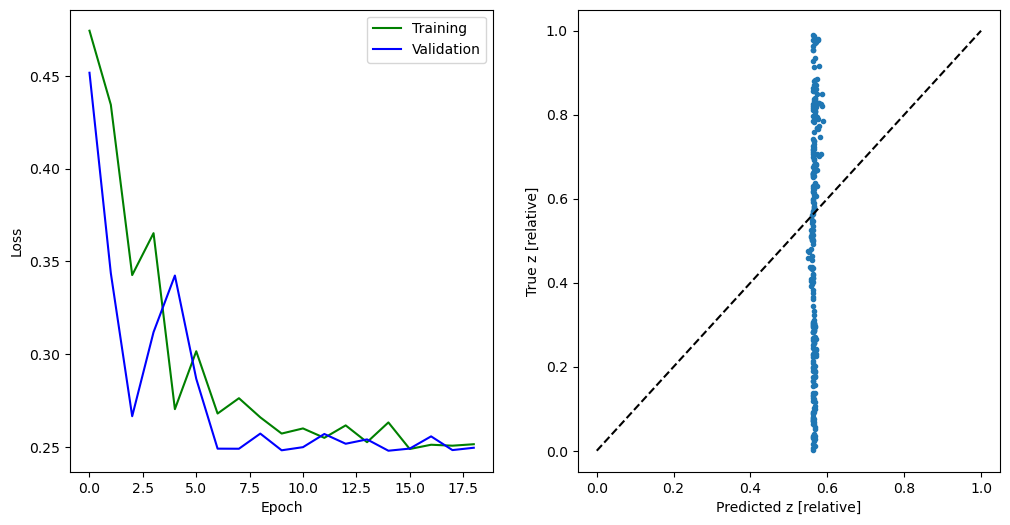

Generating 573 / 64 samples before starting training
8/8 [==============================] - 5s 655ms/step - loss: 0.2444 - val_loss: 0.2491


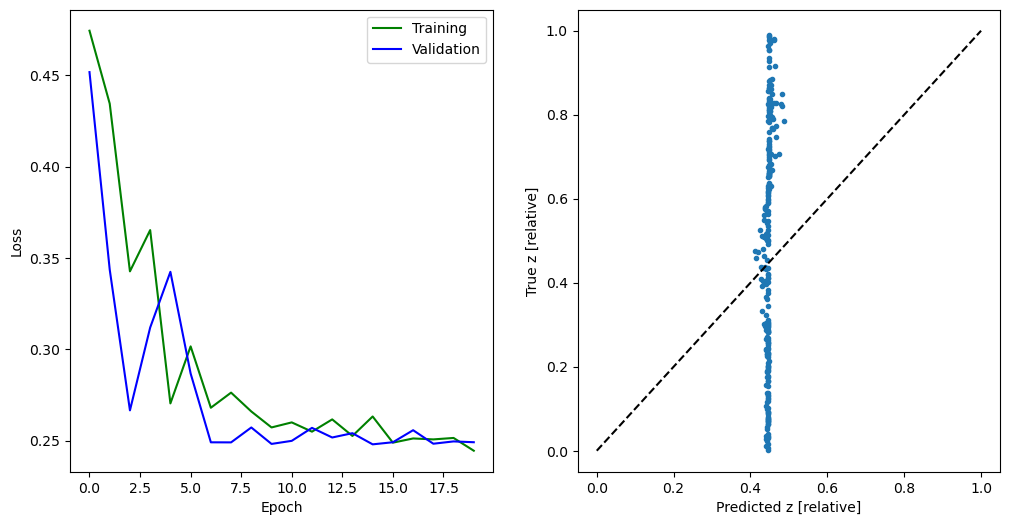

Generating 623 / 64 samples before starting training
9/9 [==============================] - 7s 823ms/step - loss: 0.2434 - val_loss: 0.2459


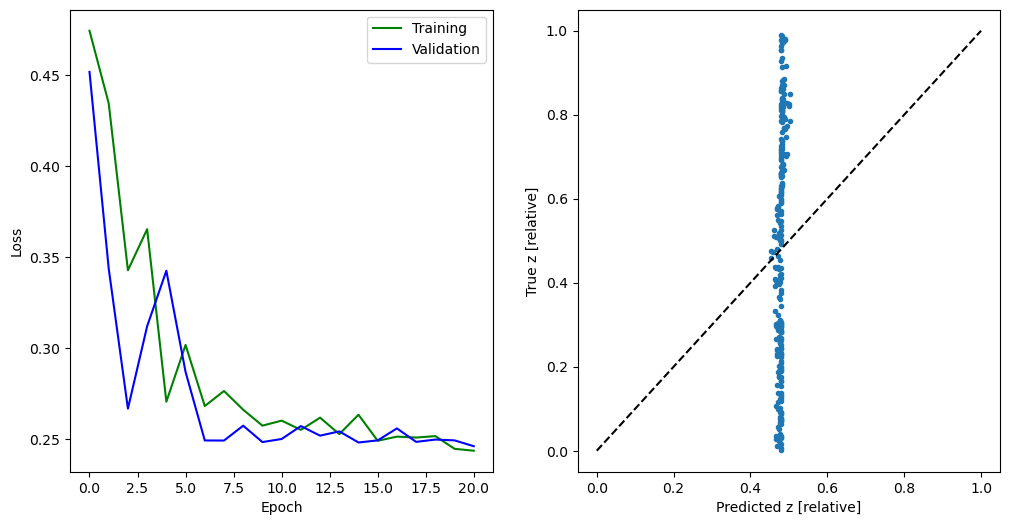

Generating 674 / 64 samples before starting training
10/10 [==============================] - 6s 644ms/step - loss: 0.2397 - val_loss: 0.2433


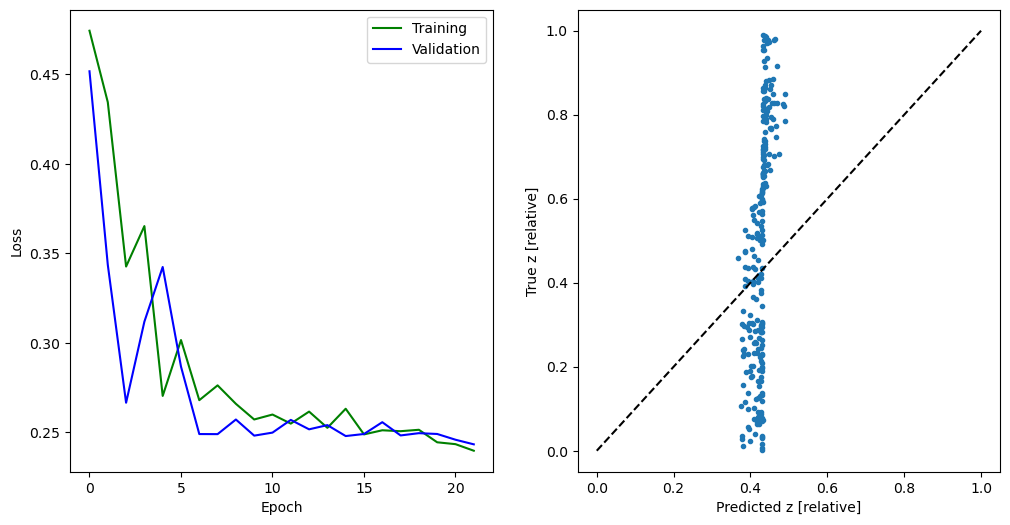

Generating 733 / 64 samples before starting training
11/11 [==============================] - 8s 754ms/step - loss: 0.2246 - val_loss: 0.1948


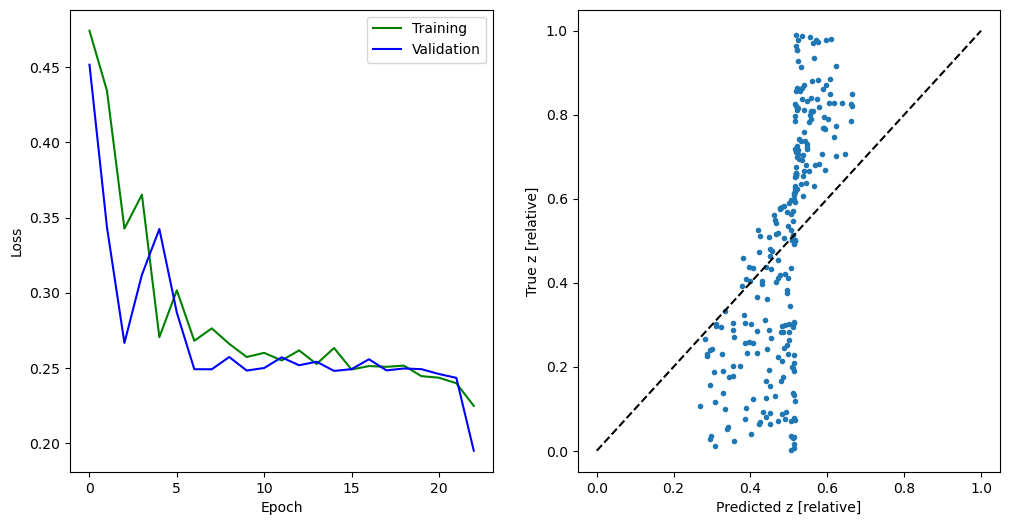

Generating 795 / 64 samples before starting training
12/12 [==============================] - 8s 682ms/step - loss: 0.1827 - val_loss: 0.1118


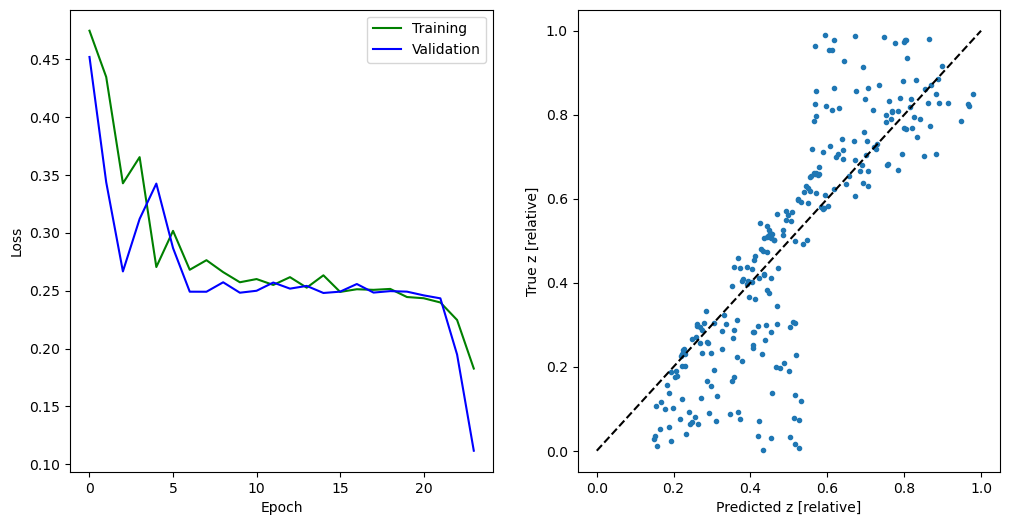

Generating 863 / 64 samples before starting training
13/13 [==============================] - 8s 627ms/step - loss: 0.1678 - val_loss: 0.1574


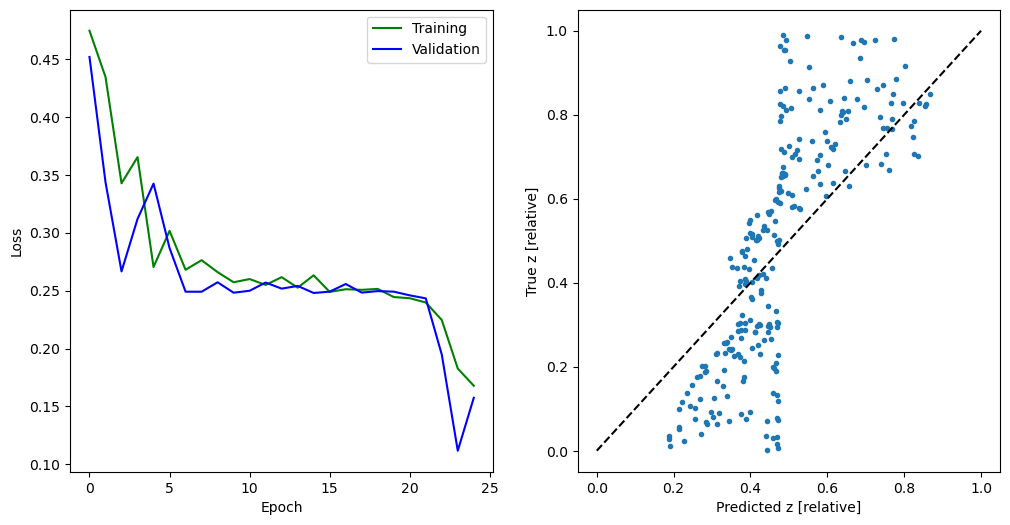

Generating 936 / 64 samples before starting training
14/14 [==============================] - 9s 609ms/step - loss: 0.1293 - val_loss: 0.0730


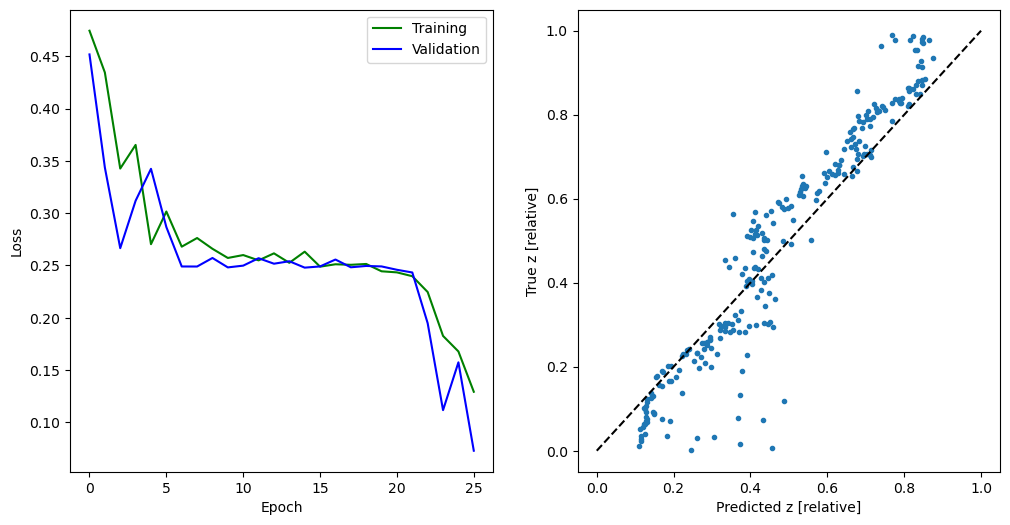

Generating 1017 / 64 samples before starting training
15/15 [==============================] - 10s 696ms/step - loss: 0.1093 - val_loss: 0.0693


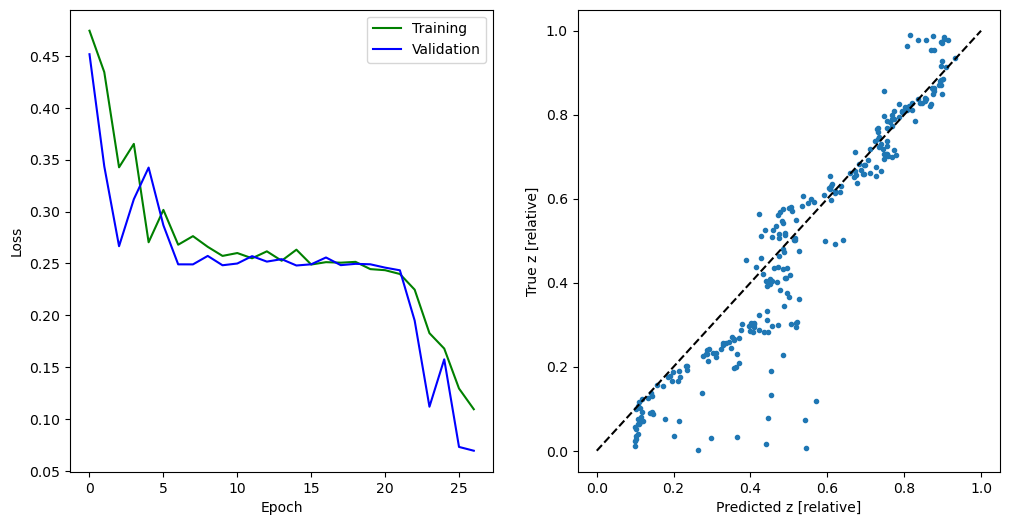

Generating 1099 / 64 samples before starting training
17/17 [==============================] - 11s 663ms/step - loss: 0.0968 - val_loss: 0.0481


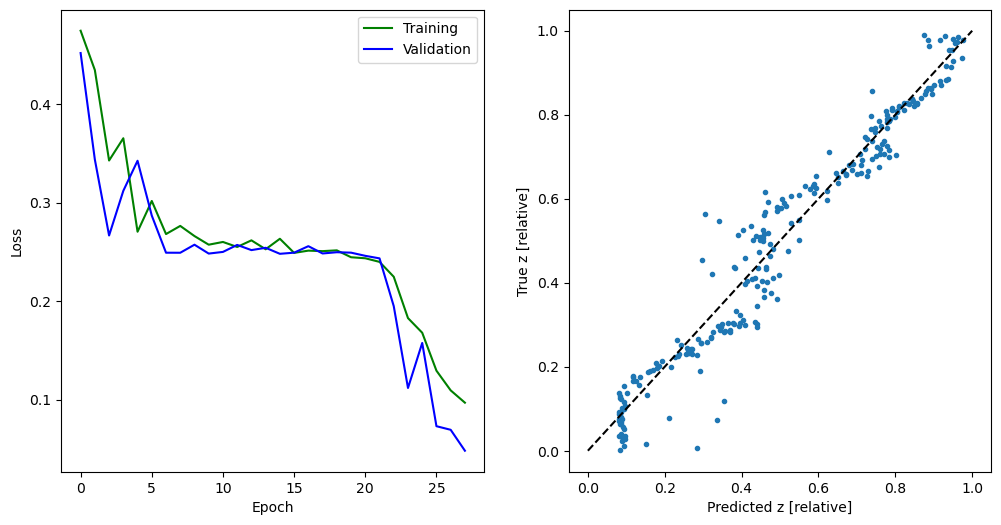

Generating 1191 / 64 samples before starting training
18/18 [==============================] - 11s 593ms/step - loss: 0.0756 - val_loss: 0.0544


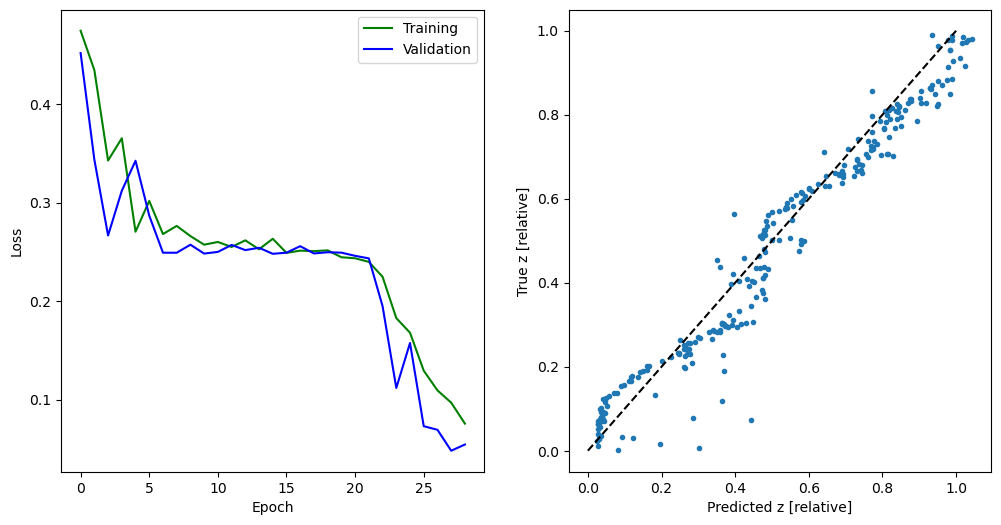

Generating 1289 / 64 samples before starting training
20/20 [==============================] - 12s 596ms/step - loss: 0.0742 - val_loss: 0.0606


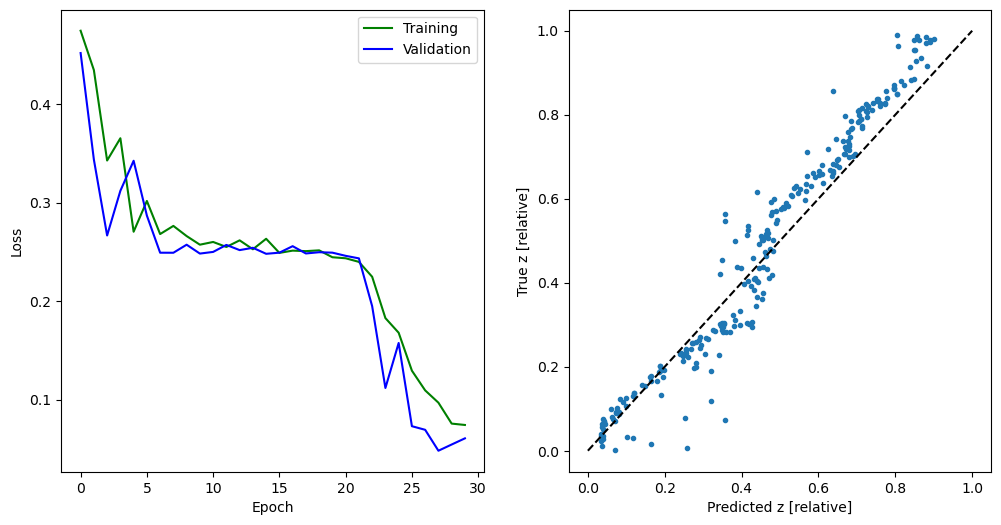

Generating 1395 / 64 samples before starting training
21/21 [==============================] - 11s 539ms/step - loss: 0.0702 - val_loss: 0.0442


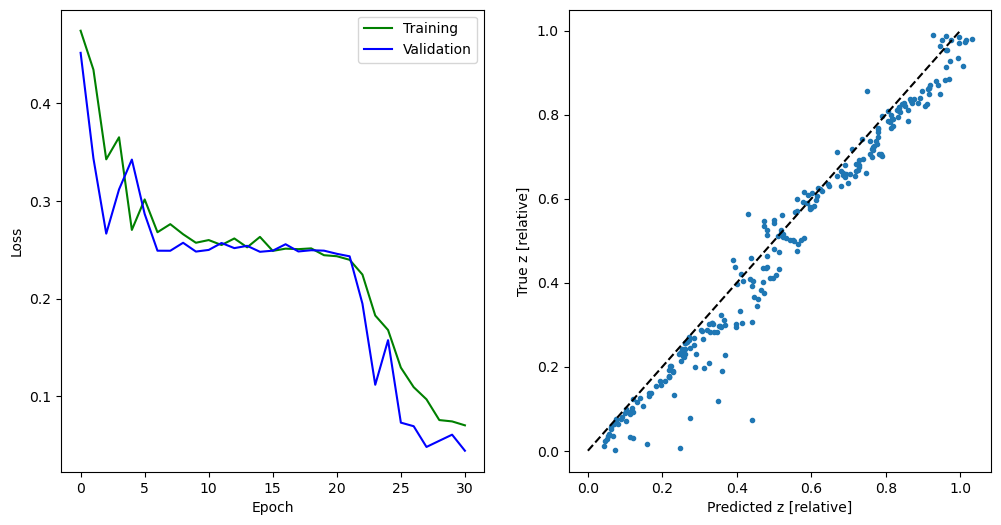

Generating 1511 / 64 samples before starting training
23/23 [==============================] - 13s 538ms/step - loss: 0.0554 - val_loss: 0.0298


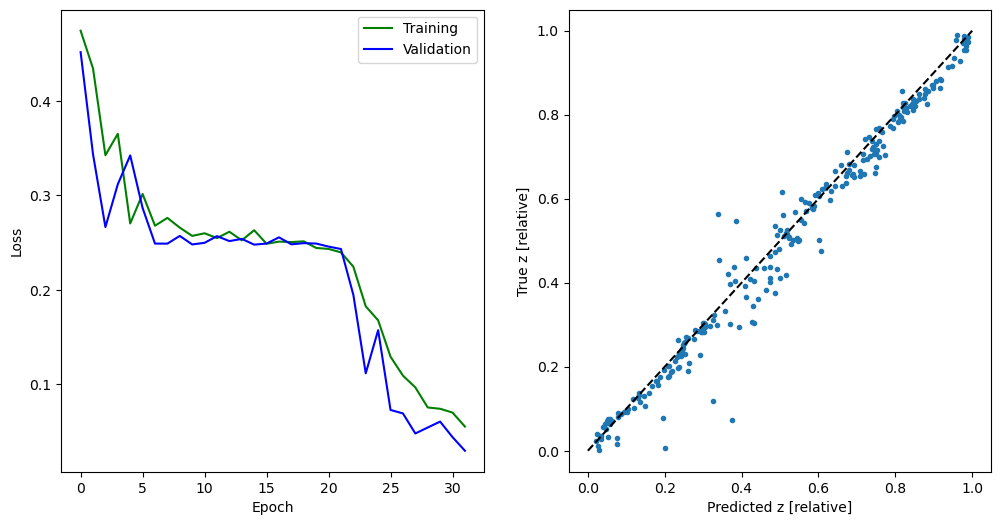

Generating 1633 / 64 samples before starting training
25/25 [==============================] - 14s 567ms/step - loss: 0.0581 - val_loss: 0.0478


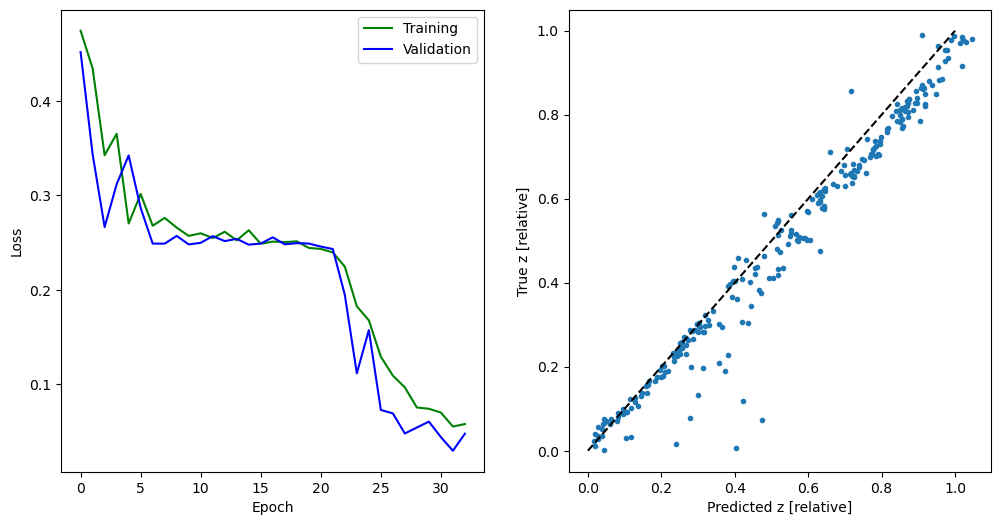

Generating 1766 / 64 samples before starting training
27/27 [==============================] - 16s 588ms/step - loss: 0.0564 - val_loss: 0.0287


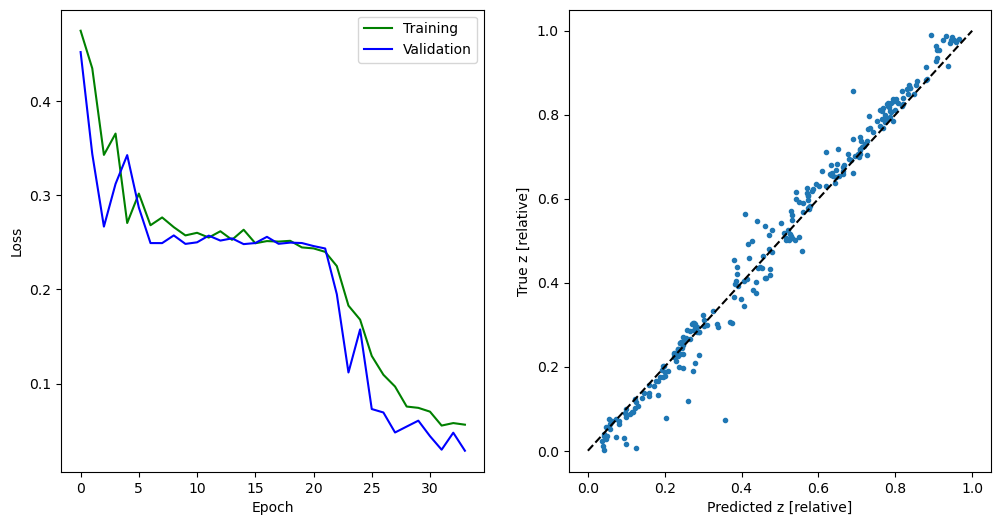

Generating 1909 / 64 samples before starting training
29/29 [==============================] - 15s 525ms/step - loss: 0.0492 - val_loss: 0.0283


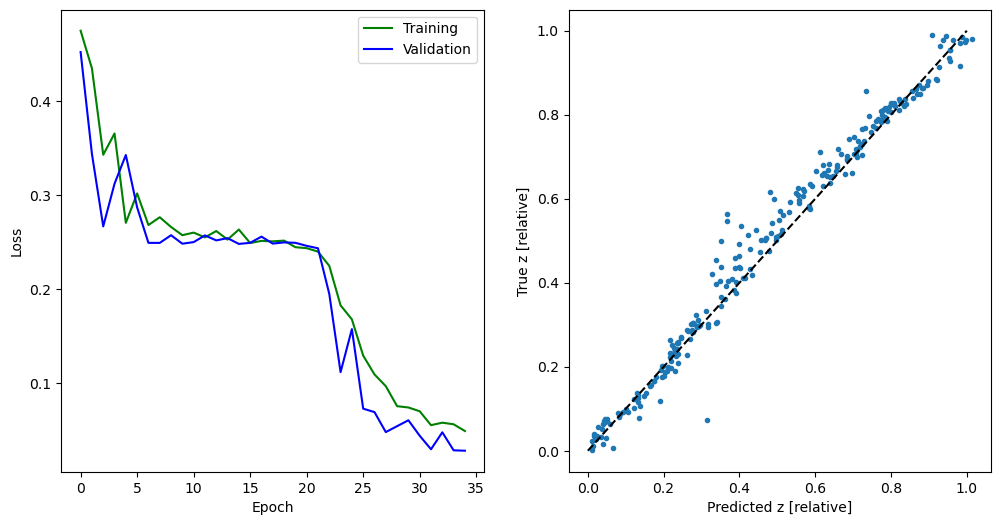

Generating 2062 / 64 samples before starting training
32/32 [==============================] - 17s 529ms/step - loss: 0.0499 - val_loss: 0.0253


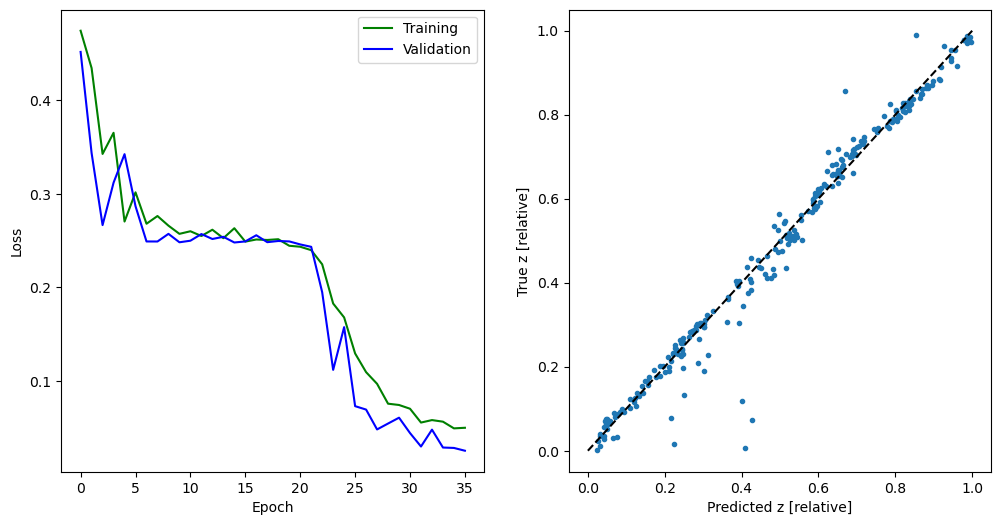

Generating 2234 / 64 samples before starting training
34/34 [==============================] - 18s 543ms/step - loss: 0.0435 - val_loss: 0.0262


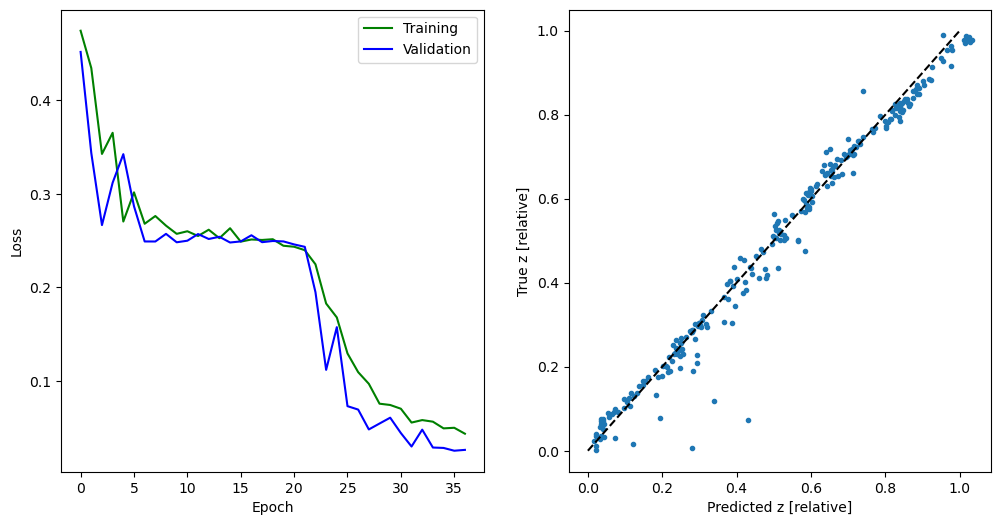

Generating 2411 / 64 samples before starting training
37/37 [==============================] - 20s 532ms/step - loss: 0.0395 - val_loss: 0.0362


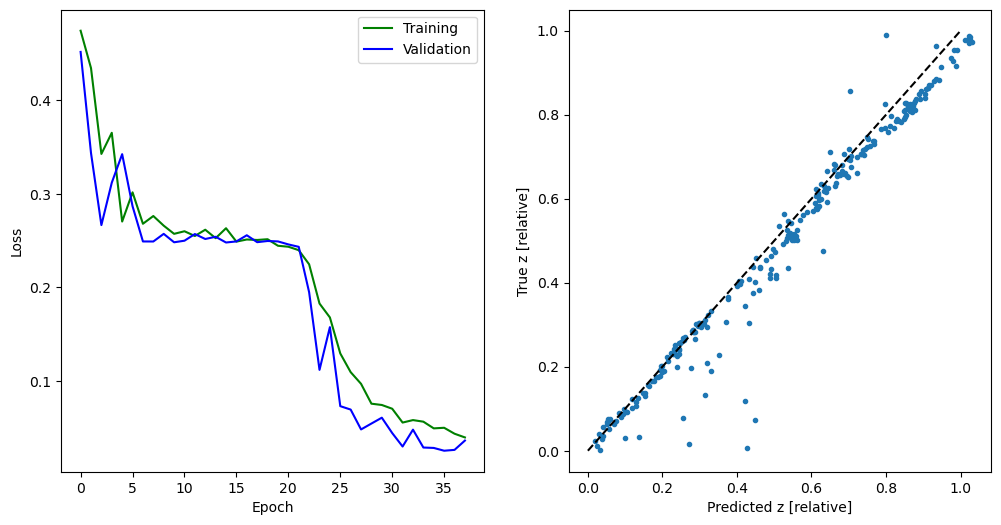

Generating 2602 / 64 samples before starting training
40/40 [==============================] - 22s 542ms/step - loss: 0.0371 - val_loss: 0.0196


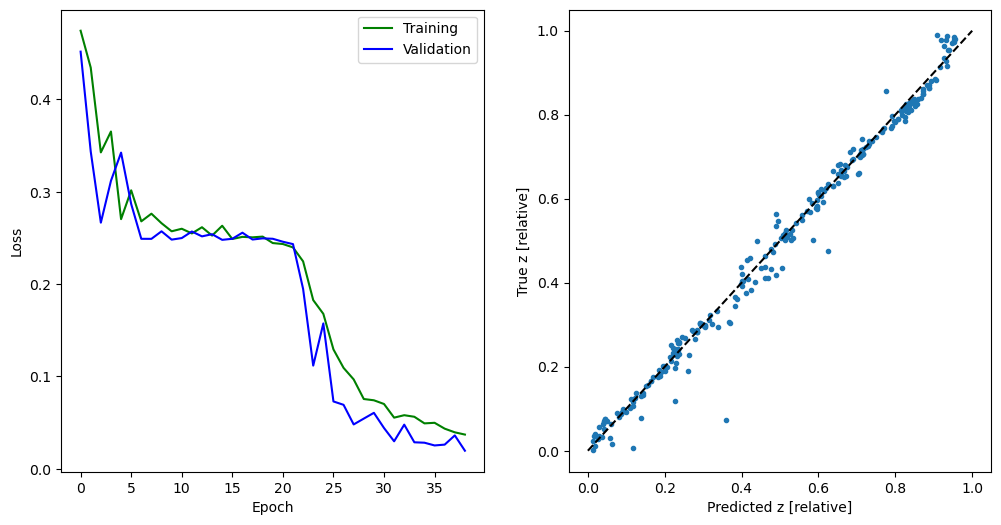

Generating 2812 / 64 samples before starting training
43/43 [==============================] - 22s 519ms/step - loss: 0.0343 - val_loss: 0.0160


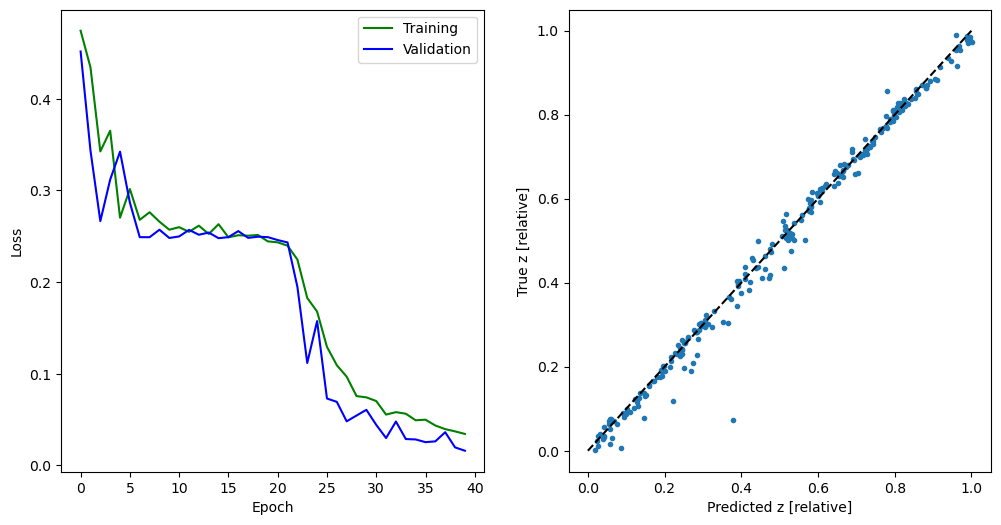

Generating 3035 / 64 samples before starting training
47/47 [==============================] - 24s 511ms/step - loss: 0.0312 - val_loss: 0.0191


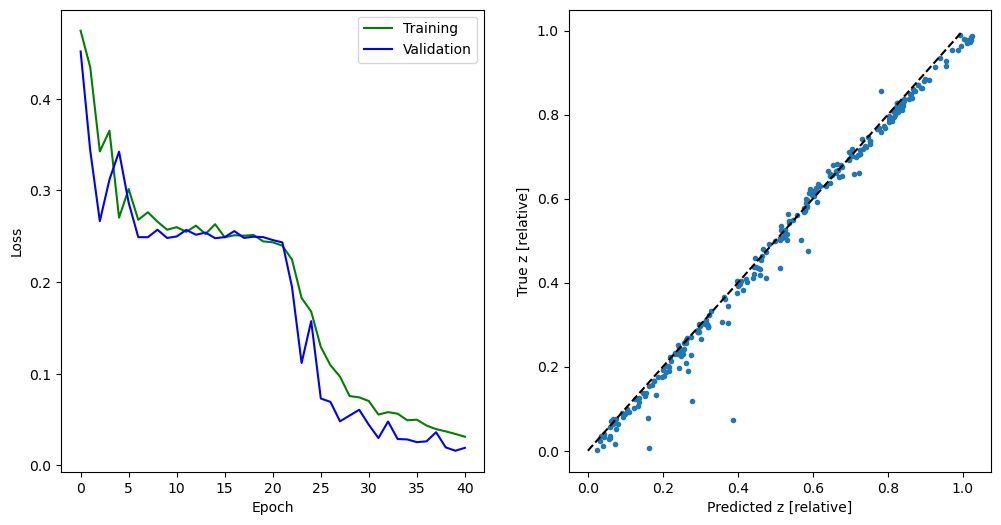

Generating 3281 / 64 samples before starting training
51/51 [==============================] - 27s 522ms/step - loss: 0.0312 - val_loss: 0.0165


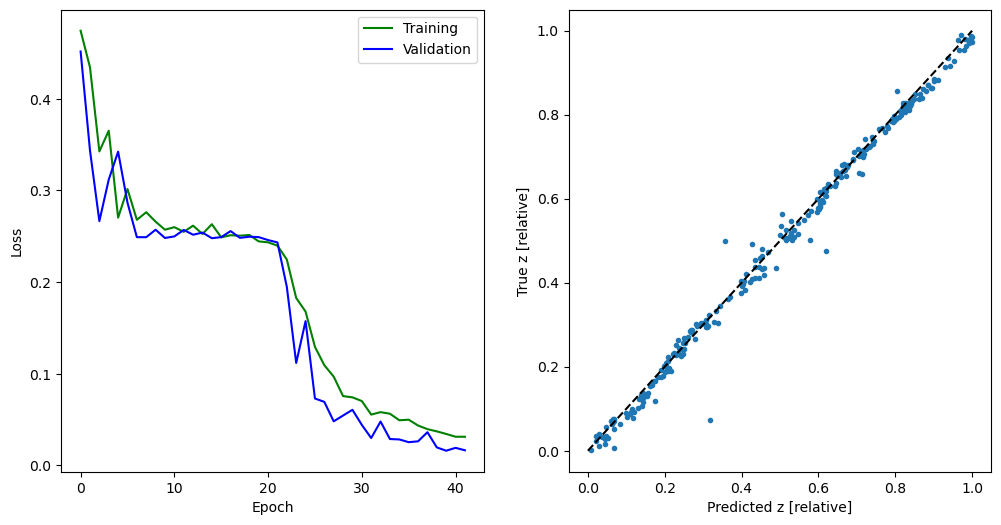

Generating 3547 / 64 samples before starting training
55/55 [==============================] - 30s 553ms/step - loss: 0.0307 - val_loss: 0.0202


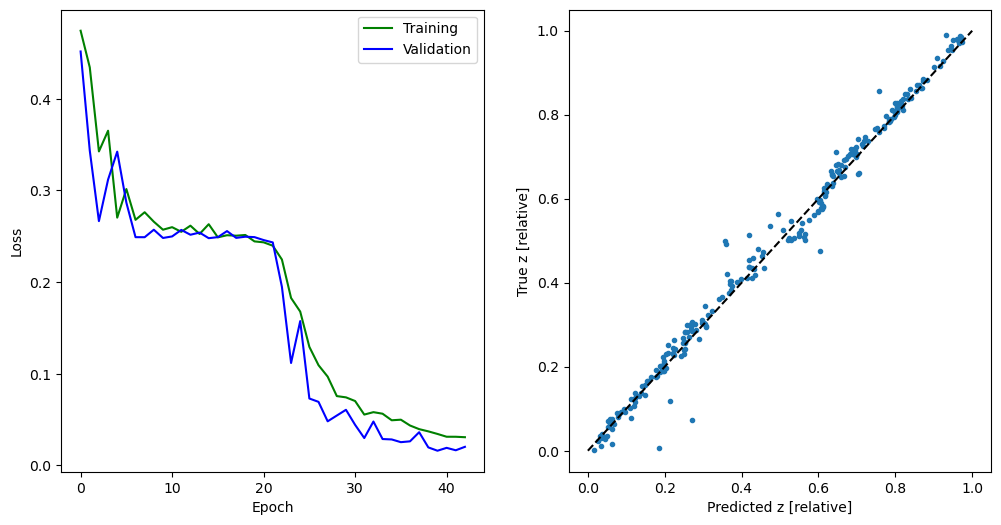

Generating 3828 / 64 samples before starting training
59/59 [==============================] - 30s 512ms/step - loss: 0.0266 - val_loss: 0.0233


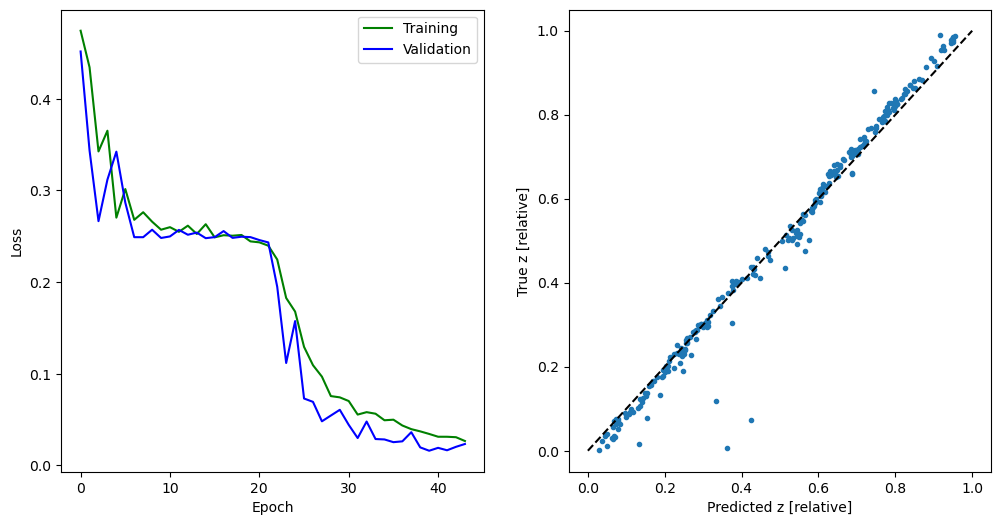

Generating 4129 / 64 samples before starting training
64/64 [==============================] - 35s 542ms/step - loss: 0.0268 - val_loss: 0.0164


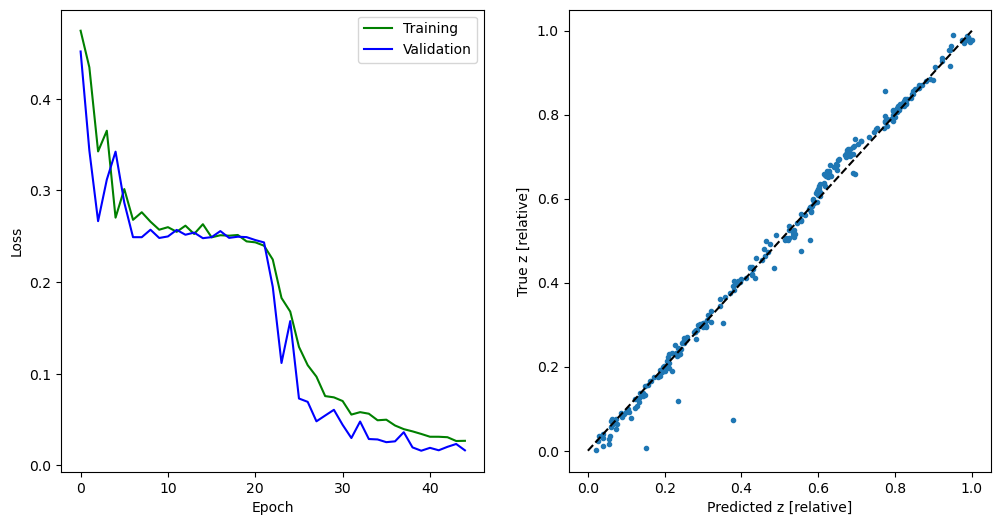

Generating 4454 / 64 samples before starting training
69/69 [==============================] - 39s 570ms/step - loss: 0.0245 - val_loss: 0.0148


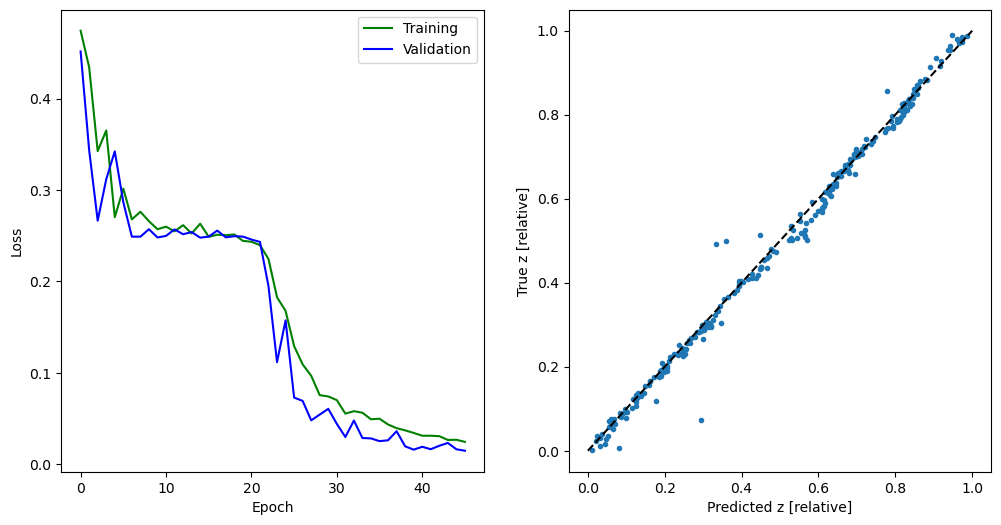

Generating 4800 / 64 samples before starting training
75/75 [==============================] - 42s 555ms/step - loss: 0.0224 - val_loss: 0.0124


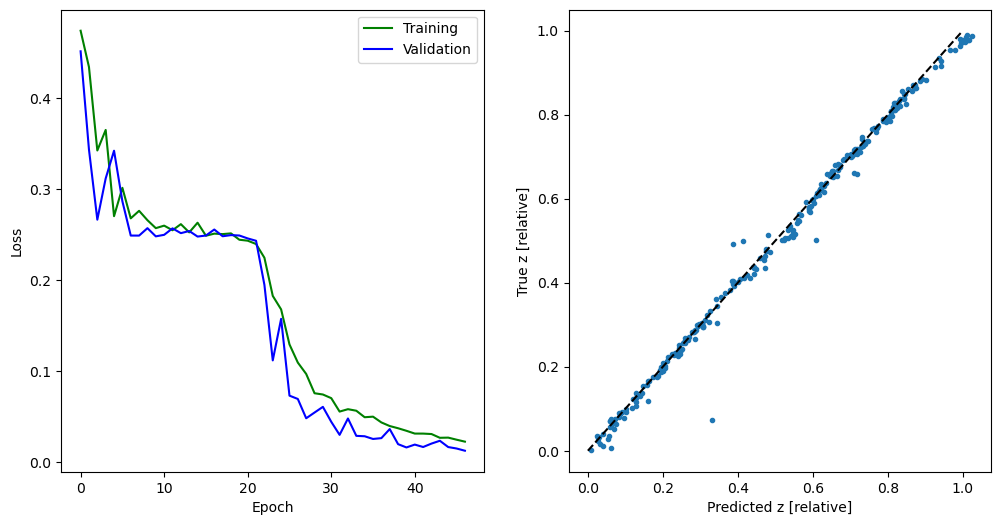

Generating 5171 / 64 samples before starting training
80/80 [==============================] - 42s 523ms/step - loss: 0.0196 - val_loss: 0.0180


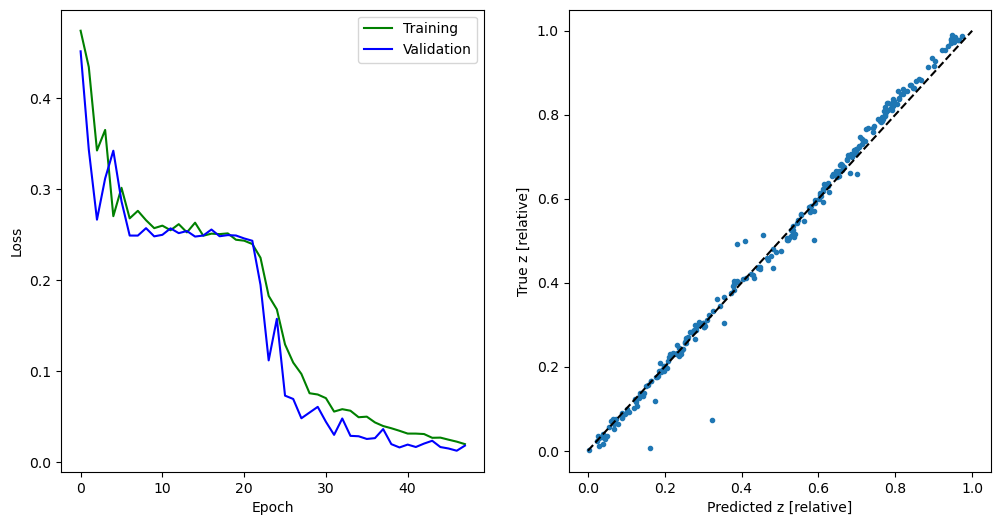

Generating 5575 / 64 samples before starting training
87/87 [==============================] - 46s 530ms/step - loss: 0.0208 - val_loss: 0.0155


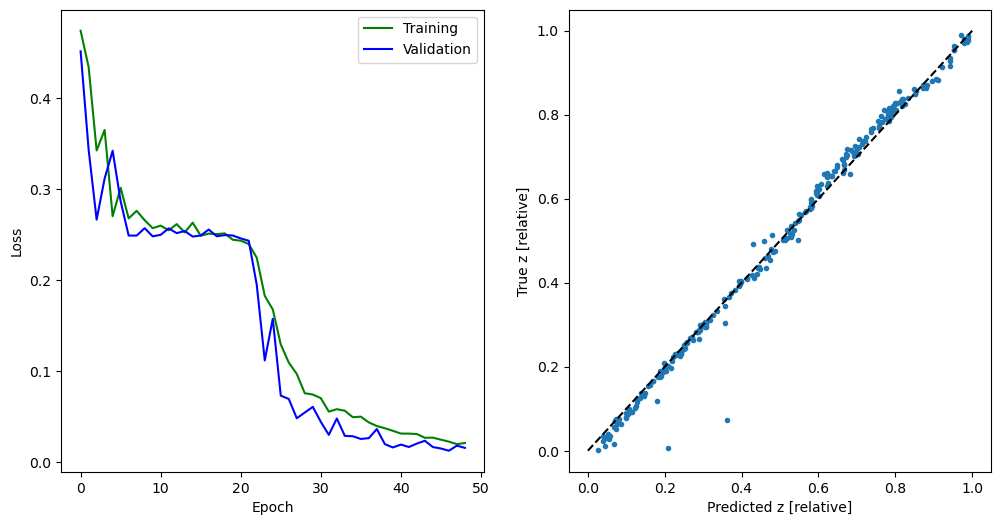

Generating 6018 / 64 samples before starting training
94/94 [==============================] - 49s 524ms/step - loss: 0.0187 - val_loss: 0.0161


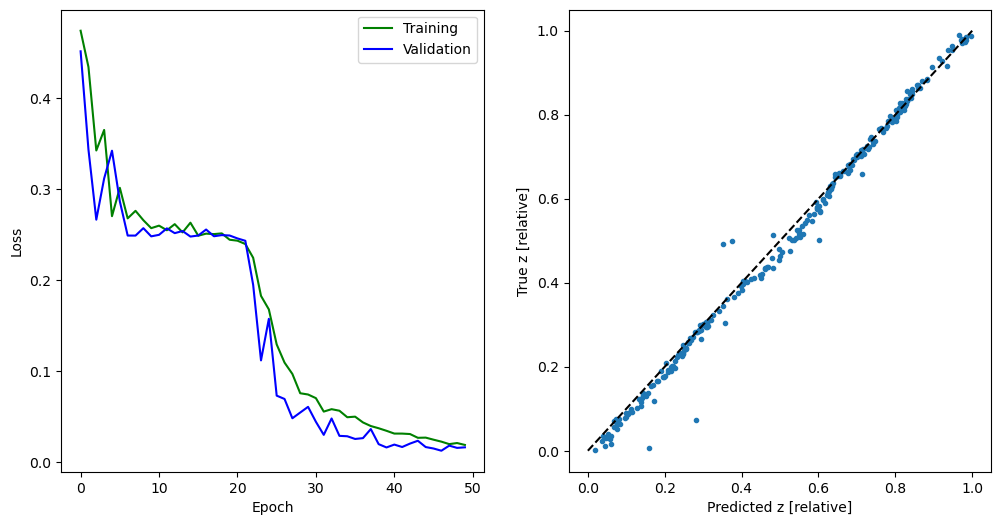

Generating 6490 / 64 samples before starting training
101/101 [==============================] - 55s 546ms/step - loss: 0.0175 - val_loss: 0.0159


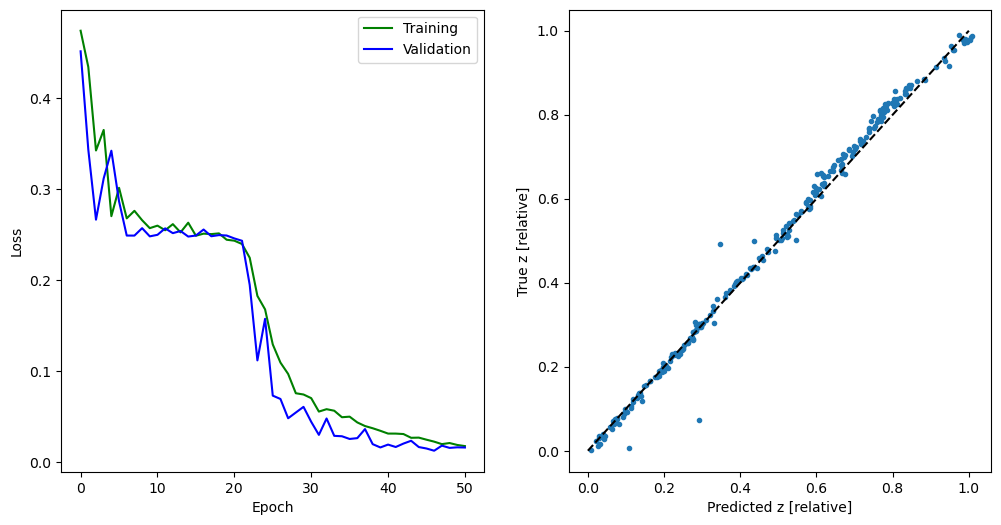

Generating 6983 / 64 samples before starting training
109/109 [==============================] - 60s 547ms/step - loss: 0.0175 - val_loss: 0.0135


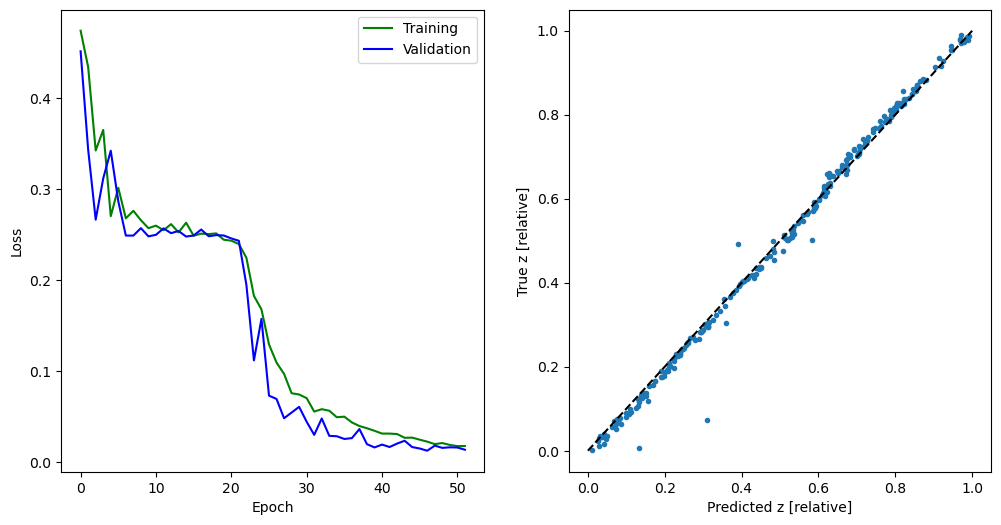

Generating 7512 / 64 samples before starting training
117/117 [==============================] - 64s 546ms/step - loss: 0.0158 - val_loss: 0.0116


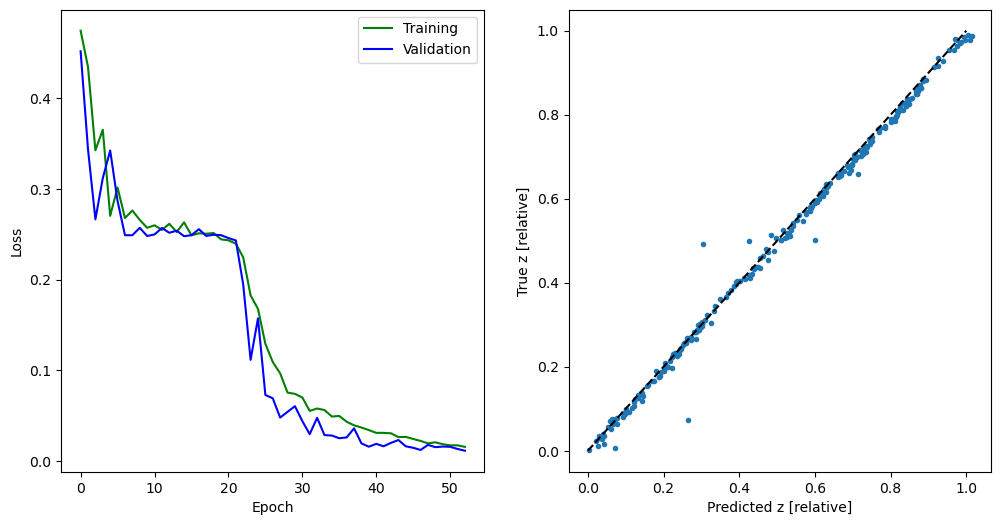

Generating 8077 / 64 samples before starting training
126/126 [==============================] - 66s 522ms/step - loss: 0.0151 - val_loss: 0.0119


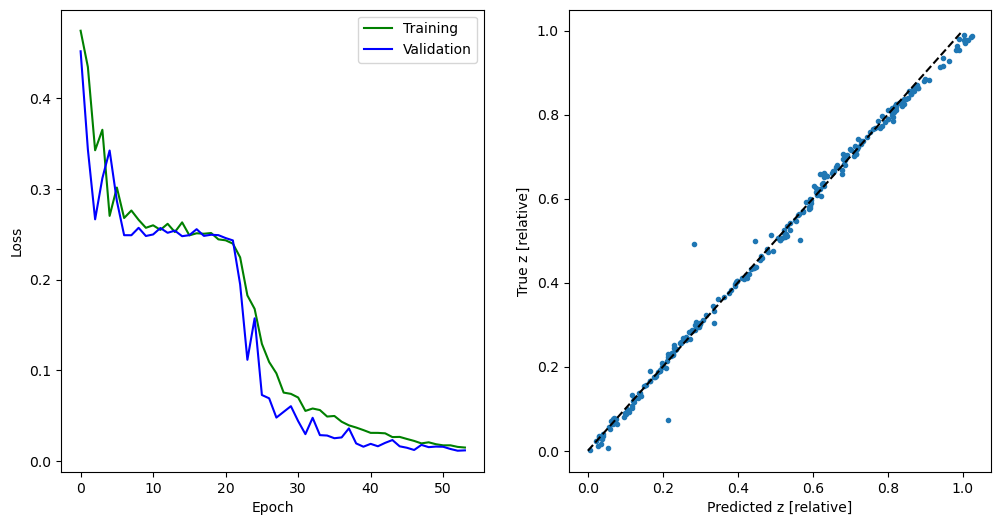

Generating 8691 / 64 samples before starting training
135/135 [==============================] - 70s 516ms/step - loss: 0.0139 - val_loss: 0.0089


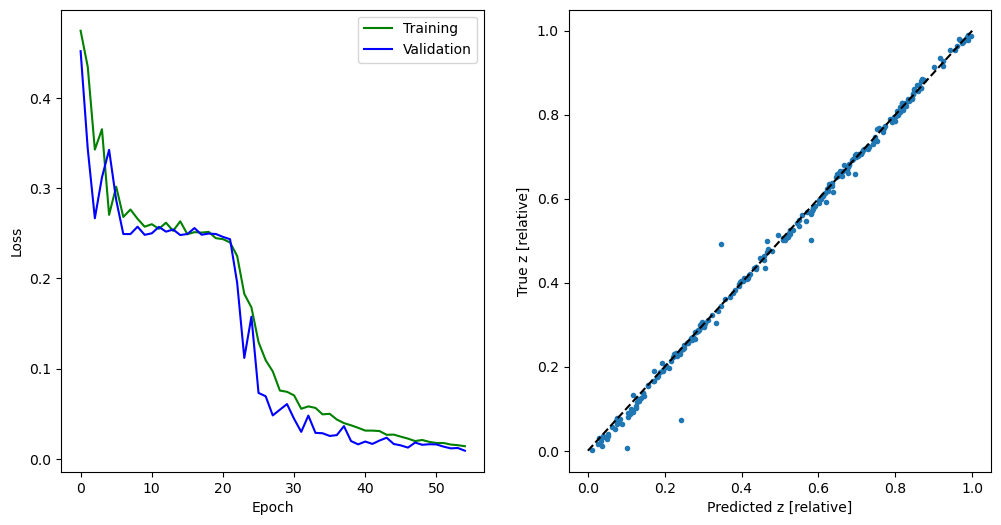

Generating 9349 / 64 samples before starting training
 71/146 [=============>................] - ETA: 39s - loss: 0.0133

KeyboardInterrupt: 

In [13]:
EPOCHS_BETWEEN_PLOTS = 1
EPOCHS_TO_TRAIN = 10000*EPOCHS_BETWEEN_PLOTS

for i in range(0, EPOCHS_TO_TRAIN, EPOCHS_BETWEEN_PLOTS):
    with generator:
        h = model.fit(
            generator,
            validation_data= (np.array(validation_set), np.array(validation_labels)),
            epochs= EPOCHS_BETWEEN_PLOTS
        )

    totalhistory["validation_loss"].extend(h.history["val_loss"])
    totalhistory["training_loss"].extend(h.history["loss"])
    totalhistory["epoch"].extend(list(range(i, i+EPOCHS_BETWEEN_PLOTS)))
    totalhistory["validation_predictions"].append(model.predict(np.array(validation_set)))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
    
    ax1.plot(totalhistory["epoch"], totalhistory["training_loss"], 'g', label = "Training")
    ax1.plot(totalhistory["epoch"], totalhistory["validation_loss"], 'b', label = "Validation")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()

    ax2.plot(totalhistory["validation_predictions"][i], validation_labels, '.')
    ax2.plot(
        np.linspace(0, 1),
        np.linspace(0, 1),
        'k--')
    ax2.set_xlabel("Predicted z [relative]")
    ax2.set_ylabel("True z [relative]")

    plt.show()


In [ ]:
%matplotlib notebook
%matplotlib notebook
import matplotlib.pyplot as plt

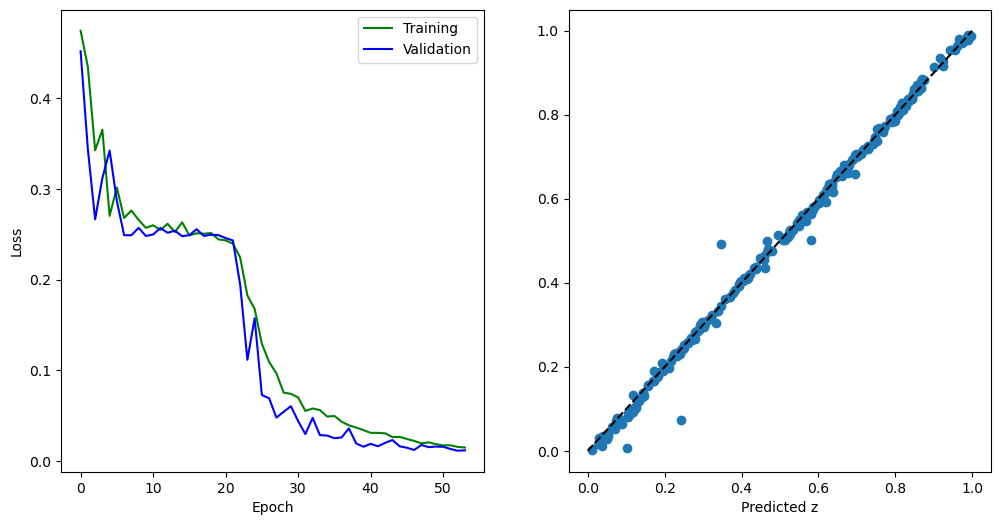

In [14]:
import matplotlib.animation as animation

figure, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))

x = np.linspace(0,1)

ax2.plot(x, x, 'k--')

def animate(i):
    ax1.clear()
    ax1.plot(totalhistory["epoch"][:i], totalhistory["training_loss"][:i], 'g', label = "Training")
    ax1.plot(totalhistory["epoch"][:i], totalhistory["validation_loss"][:i], 'b', label = "Validation")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()

    #if i == 0:
    #    ax1.legend()

    ax2.clear()
    ax2.set_xlabel("Predicted z")
    ax2.plot(x, x, 'k--')
    ax2.scatter(totalhistory["validation_predictions"][i], validation_labels)

myAnimation = animation.FuncAnimation(figure, animate, frames= len(totalhistory["validation_predictions"]), interval= 150)
myAnimation.save("mymovie.mp4")

In [19]:
import tensorflow as tf

model.summary()
tf.keras.utils.plot_model(model, to_file="my_model.png", show_shapes=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 2)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        608       
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 spatial_dropout2d (SpatialD  (None, 64, 64, 32)       0         
 ropout2D)                                                       
                                                             